In [2]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV

In [3]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

In [4]:
import shap
import joblib
import pickle
shap.initjs()

c:\Users\dell\anaconda3\envs\reg_forest\lib\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
c:\Users\dell\anaconda3\envs\reg_forest\lib\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_orde

In [5]:
from econml.grf import RegressionForest

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import joblib
import textwrap
from importlib.machinery import SourceFileLoader

In [7]:
fun = SourceFileLoader( 'funciones', r'..\..\..\code\modules\funciones.py' ).load_module()
vn  = SourceFileLoader( 'variables_nombres', r'..\..\..\code\modules\variables_nombres.py' ).load_module()

# 1. Cross Validation Plots

### 1.1. Intense Corruption

We select the best performing model (Random Forest ST) and get the grid search results

In [7]:
df_gs_ci = pd.read_excel( r'..\..\..\output\ejecucion_8\gridsearch_results\gs_ci_Random Forest Classifier_st.xlsx')

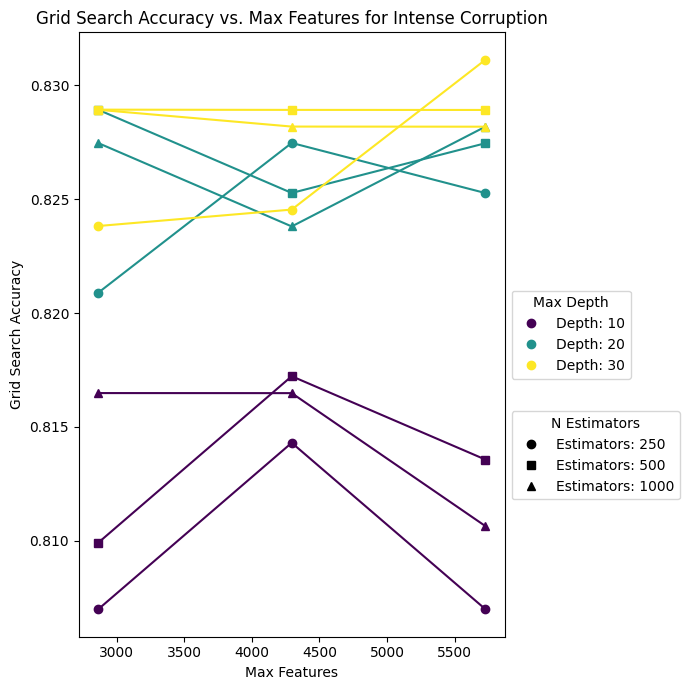

In [8]:
# Definir colores y marcadores únicos
depth_colors = {depth: color for depth, color in zip(sorted(df_gs_ci['param_max_depth'].unique()), plt.cm.viridis(np.linspace(0, 1, len(df_gs_ci['param_max_depth'].unique()))))}
estimators_markers = {est: marker for est, marker in zip(sorted(df_gs_ci['param_n_estimators'].unique()), ['o', 's', '^', 'd', '*', 'P', 'X'])}

plt.figure(figsize=(7, 7))

# Iterar sobre cada combinación de 'max_depth' y 'n_estimators' y graficar
for (max_depth, n_estimators), group_data in df_gs_ci.groupby(['param_max_depth', 'param_n_estimators']):
    sorted_group_data = group_data.sort_values('param_max_features')
    plt.plot(sorted_group_data['param_max_features'], sorted_group_data['mean_test_score'],
             color=depth_colors[max_depth], marker=estimators_markers[n_estimators], linestyle='-')

# Crear leyendas
# Leyenda para max_depth (color)
depth_legend = [mlines.Line2D([], [], color=color, marker='o', linestyle='None', label=f'Depth: {depth}')
                for depth, color in depth_colors.items()]

# Leyenda para n_estimators (marcador)
estimators_legend = [mlines.Line2D([], [], color='black', marker=marker, linestyle='None', label=f'Estimators: {est}')
                     for est, marker in estimators_markers.items()]

# Agregar leyendas al gráfico
legend_depth = plt.legend(handles=depth_legend, title='Max Depth', loc='center left', bbox_to_anchor=(1, 0.5), frameon=True)
plt.gca().add_artist(legend_depth)
plt.legend(handles=estimators_legend, title='N Estimators', loc='center left', bbox_to_anchor=(1, 0.3), frameon=True)

# Configurar gráfico
plt.xlabel('Max Features')
plt.ylabel('Grid Search Accuracy')
plt.title('Grid Search Accuracy vs. Max Features for Intense Corruption')
plt.tight_layout()
plt.savefig(r'..\..\..\output\ejecucion_8\plots\ci_rf_st.png', bbox_inches='tight')
plt.show()

### 1.2. Broad Corruption

In [172]:
df_gs_ca = pd.read_excel( r'..\..\..\output\ejecucion_8\gridsearch_results\gs_ca_Regression Forest_nro.xlsx')

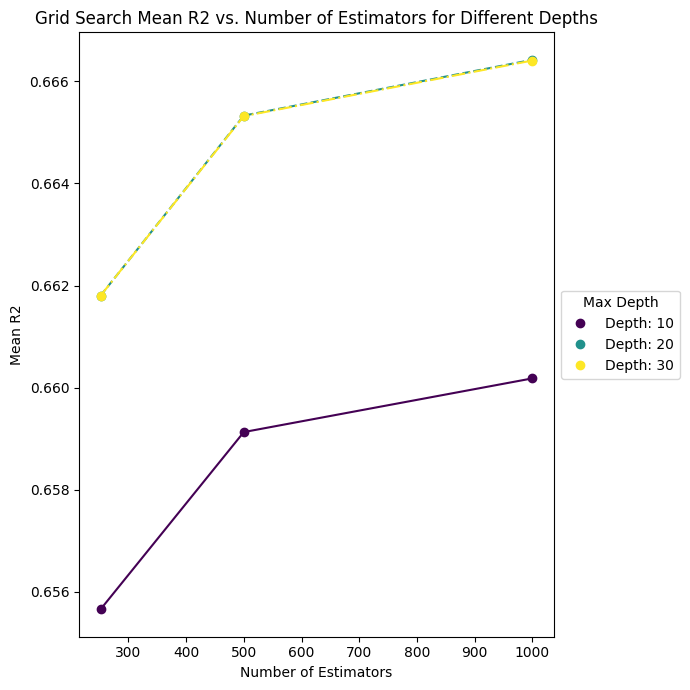

In [184]:
# Definir colores y marcadores únicos
depth_colors = {depth: color for depth, color in zip(sorted(df_gs_ca['param_max_depth'].unique()), plt.cm.viridis(np.linspace(0, 1, len(df_gs_ca['param_max_depth'].unique()))))}

plt.figure(figsize=(7, 7))

line_styles = ['-', '--', '-.', ':']
for i, max_depth in enumerate(sorted(df_gs_ca['param_max_depth'].unique())):
    filtered_data = df_gs_ca[df_gs_ca['param_max_depth'] == max_depth]
    plt.plot(filtered_data['param_n_estimators'], filtered_data['mean_test_score'],
             label=f'Depth: {max_depth}', marker='o', linestyle=line_styles[i % len(line_styles)], color=depth_colors[max_depth])

# Configurar el gráfico
plt.xlabel('Number of Estimators')
plt.ylabel('Mean R2')
plt.title('Grid Search Mean R2 vs. Number of Estimators for Different Depths')
plt.legend(handles=depth_legend, title='Max Depth', loc='center left', bbox_to_anchor=(1, 0.5), frameon=True)

plt.tight_layout()
# Descomenta la siguiente línea para guardar la figura en tu sistema de archivos
plt.savefig(r'..\..\..\output\ejecucion_8\plots\ca_regf_nro.png', bbox_inches='tight')
# plt.show()


# 2. Canon Correlation Plots

## 2.1. Intense Corruption

### 2.1.1. Gini Criteria

In [44]:
path = r'..\..\..\input\preprocessed_data\base0_siaf_canon_1620.csv'
data = pd.read_csv( path )

In [45]:
data = data.rename( columns = { 'totaldev_canon'  : 'Canon: Total devengado', 
                                '_totaldev_canon' : 'Canon: Total devengado rezagado',
                                'totaldev_canonpc': 'Canon: Total devengado per cápita',
                                'totaleje_canon'  : 'Canon: Total ejecutado',
                                '_totaleje_canon' : 'Canon: Total ejecutado rezagado',
                                'totaleje_canonpc': 'Canon: Total ejecutado per cápita',
                                'pim_canon'       : 'Canon: PIM',
                                '_pim_canon': 'Canon: PIM rezagado',
                                'pim_canonpc': 'Canon: PIM per cápita' } )


variable_labels = {
    "_tejgtotfun_f5r07ambpc": "Total Ejecutado rezagado per cápita de la Fuente 5 (Recursos Determinados) en el Rubro 07 (Fondo de Compensación Municipal) para el gasto total de la Función de Ambiente",
    "_tejgtotfun_f5r07amb": "Total Ejecutado rezagado de la Fuente 5 (Recursos Determinados) en el Rubro 07 (Fondo de Compensación Municipal) para el gasto total de la Función de Ambiente",
    "_tejgtotfun_f5r18amb": "Total Ejecutado rezagado de la Fuente 5 (Recursos Determinados) en el Rubro 18 (Canon y Sobrecanon, Regalías, Renta de Aduanas y Participaciones) para el gasto total de la Función de Ambiente",
    "_tejgfun_f5ct06amb": "Total Ejecutado rezagado de la Fuente 5 (Recursos Determinados) en la Categoría 6 (Gastos de Capital) para la Función de Ambiente",
    "_tejgfun_f5ct06ambpc": "Total Ejecutado rezagado per cápita de la Fuente 5 (Recursos Determinados) en la Categoría 6 (Gastos de Capital) para la Función de Ambiente",
    "devppimfun_f5ct05salud": "Porcentaje del Presupuesto Institucional Modificado (PIM) que ha sido Devengado de la Fuente 5 (Recursos Determinados) en la Categoría 5 (Gastos Corrientes) para la Función de Salud",
    "_tejgtotfun_f5r08pgrcopc": "Total Ejecutado rezagado per cápita de la Fuente 5 (Recursos Determinados) en el Rubro 08 (Impuestos Municipales) para el gasto total de la Función de Planeamiento, Gestión y Reserva de Contingencia",
    "devppimtotfun_f5r18opseg": "Porcentaje del Presupuesto Institucional Modificado (PIM) que ha sido Devengado de la Fuente 5 (Recursos Determinados) en el Rubro 18 (Canon y Sobrecanon, Regalías, Renta de Aduanas y Participaciones) para el gasto total de la Función de Orden Público y Seguridad",
    "_tejgtotfun_f5r18ambpc": "Total Ejecutado rezagado per cápita de la Fuente 5 (Recursos Determinados) en el Rubro 18 (Canon y Sobrecanon, Regalías, Renta de Aduanas y Participaciones) para el gasto total de la Función de Ambiente",
    "devppimfun_f5r18ct05prots": "Porcentaje del Presupuesto Institucional Modificado (PIM) que ha sido Devengado de la Fuente 5 (Recursos Determinados) en el Rubro 18 (Canon y Sobrecanon, Regalías, Renta de Aduanas y Participaciones) en la Categoría 5 (Gastos Corrientes) para la Función de Protección Social",
    "_tejgtotfun_f5r08pgrco": "Total Ejecutado rezagado de la Fuente 5 (Recursos Determinados) en el Rubro 08 (Impuestos Municipales) para el gasto total de la Función de Planeamiento, Gestión y Reserva de Contingencia",
    "_devppimfun_f1ct05trans": "Porcentaje del Presupuesto Institucional Modificado (PIM) rezagado que ha sido Devengado de la Fuente 1 (Recursos Ordinarios) en la Categoría 5 (Gastos Corrientes) para la Función de Transporte",
    "_tejgfun_f5r08ct05prots": "Total Ejecutado rezagado de la Fuente 5 (Recursos Determinados) en el Rubro 08 (Impuestos Municipales) para la Categoría 5 (Gastos Corrientes) de la Función de Protección Social",
    "_devppimfun_f5r18ct05opseg": "Porcentaje rezagado del Presupuesto Institucional Modificado (PIM) que ha sido Devengado de la Fuente 5 (Recursos Determinados) en el Rubro 18 (Canon y Sobrecanon, Regalías, Renta de Aduanas y Participaciones) en la Categoría 5 (Gastos Corrientes) para la Función de Orden Público y Seguridad",
    "_devppimtotfun_f5r18opseg": "Porcentaje rezagado del Presupuesto Institucional Modificado (PIM) que ha sido Devengado de la Fuente 5 (Recursos Determinados) en el Rubro 18 (Canon y Sobrecanon, Regalías, Renta de Aduanas y Participaciones) para el gasto total de la Función de Orden Público y Seguridad",
    "piagfun_f5r07ct05trans": "Presupuesto Institucional de Apertura de la Fuente 5 (Recursos Determinados) en el Rubro 07 (Fondo de Compensación Municipal) para la Categoría 5 (Gastos Corrientes) de la Función de Transporte",
    "_tejgfun_f5r18ct05pgrcopc": "Total Ejecutado rezagado per cápita de la Fuente 5 (Recursos Determinados) en el Rubro 18 (Canon y Sobrecanon, Regalías, Renta de Aduanas y Participaciones) para la Categoría 5 (Gastos Corrientes) de la Función de Planeamiento, Gestión y Reserva de Contingencia",
    "_tejgkft_redrpc": "_tejgkft_redrpc",
    "_tejgct_r09gstcppc": "Total Ejecutado rezagado per cápita en el rubro 09 (Recursos Directamente Recaudados) para la categoría de Gastos de Capital",
    "pimgfun_f5r18ct05cydeppc": "Presupuesto Institucional Modificado (PIM) per cápita de la Fuente 5 (Recursos Determinados), en el Rubro 18 (Canon y Sobrecanon, Regalías, Renta de Aduanas y Participaciones), para la Categoría 5 (Gastos Corrientes) de la función Cultura y Deporte"
}

most_important_vars_ci = [
    "Total Ejecutado rezagado per cápita de la Fuente 5 (Recursos Determinados) en el Rubro 07 (Fondo de Compensación Municipal) para el gasto total de la Función de Ambiente",
    "Total Ejecutado rezagado de la Fuente 5 (Recursos Determinados) en el Rubro 07 (Fondo de Compensación Municipal) para el gasto total de la Función de Ambiente",
    "Total Ejecutado rezagado de la Fuente 5 (Recursos Determinados) en el Rubro 18 (Canon y Sobrecanon, Regalías, Renta de Aduanas y Participaciones) para el gasto total de la Función de Ambiente",
    "Total Ejecutado rezagado de la Fuente 5 (Recursos Determinados) en la Categoría 6 (Gastos de Capital) para la Función de Ambiente",
    "Total Ejecutado rezagado per cápita de la Fuente 5 (Recursos Determinados) en la Categoría 6 (Gastos de Capital) para la Función de Ambiente",
    "Porcentaje del Presupuesto Institucional Modificado (PIM) que ha sido Devengado de la Fuente 5 (Recursos Determinados) en la Categoría 5 (Gastos Corrientes) para la Función de Salud",
    "Total Ejecutado rezagado per cápita de la Fuente 5 (Recursos Determinados) en el Rubro 08 (Impuestos Municipales) para el gasto total de la Función de Planeamiento, Gestión y Reserva de Contingencia",
    "Porcentaje del Presupuesto Institucional Modificado (PIM) que ha sido Devengado de la Fuente 5 (Recursos Determinados) en el Rubro 18 (Canon y Sobrecanon, Regalías, Renta de Aduanas y Participaciones) para el gasto total de la Función de Orden Público y Seguridad",
    "Total Ejecutado rezagado per cápita de la Fuente 5 (Recursos Determinados) en el Rubro 18 (Canon y Sobrecanon, Regalías, Renta de Aduanas y Participaciones) para el gasto total de la Función de Ambiente",
    "Porcentaje del Presupuesto Institucional Modificado (PIM) que ha sido Devengado de la Fuente 5 (Recursos Determinados) en el Rubro 18 (Canon y Sobrecanon, Regalías, Renta de Aduanas y Participaciones) en la Categoría 5 (Gastos Corrientes) para la Función de Protección Social",
    "Total Ejecutado rezagado de la Fuente 5 (Recursos Determinados) en el Rubro 08 (Impuestos Municipales) para el gasto total de la Función de Planeamiento, Gestión y Reserva de Contingencia",
    "Porcentaje del Presupuesto Institucional Modificado (PIM) rezagado que ha sido Devengado de la Fuente 1 (Recursos Ordinarios) en la Categoría 5 (Gastos Corrientes) para la Función de Transporte",
    "Total Ejecutado rezagado de la Fuente 5 (Recursos Determinados) en el Rubro 08 (Impuestos Municipales) para la Categoría 5 (Gastos Corrientes) de la Función de Protección Social",
    "Porcentaje rezagado del Presupuesto Institucional Modificado (PIM) que ha sido Devengado de la Fuente 5 (Recursos Determinados) en el Rubro 18 (Canon y Sobrecanon, Regalías, Renta de Aduanas y Participaciones) en la Categoría 5 (Gastos Corrientes) para la Función de Orden Público y Seguridad",
    "Porcentaje rezagado del Presupuesto Institucional Modificado (PIM) que ha sido Devengado de la Fuente 5 (Recursos Determinados) en el Rubro 18 (Canon y Sobrecanon, Regalías, Renta de Aduanas y Participaciones) para el gasto total de la Función de Orden Público y Seguridad",
    "Presupuesto Institucional de Apertura de la Fuente 5 (Recursos Determinados) en el Rubro 07 (Fondo de Compensación Municipal) para la Categoría 5 (Gastos Corrientes) de la Función de Transporte",
    "Total Ejecutado rezagado per cápita de la Fuente 5 (Recursos Determinados) en el Rubro 18 (Canon y Sobrecanon, Regalías, Renta de Aduanas y Participaciones) para la Categoría 5 (Gastos Corrientes) de la Función de Planeamiento, Gestión y Reserva de Contingencia",
    "_tejgkft_redrpc",
    "Total Ejecutado rezagado per cápita en el rubro 09 (Recursos Directamente Recaudados) para la categoría de Gastos de Capital",
    "Presupuesto Institucional Modificado (PIM) per cápita de la Fuente 5 (Recursos Determinados), en el Rubro 18 (Canon y Sobrecanon, Regalías, Renta de Aduanas y Participaciones), para la Categoría 5 (Gastos Corrientes) de la función Cultura y Deporte"
]

data = data.rename(columns={var: variable_labels[var] for var in data.columns if var in variable_labels})

canon_vars          = [ 'Canon: Total devengado', 'Canon: Total devengado rezagado', 'Canon: Total devengado per cápita', 
                        'Canon: Total ejecutado', 'Canon: Total ejecutado rezagado', 'Canon: Total ejecutado per cápita',
                        'Canon: PIM', 'Canon: PIM rezagado', 'Canon: PIM per cápita' ]

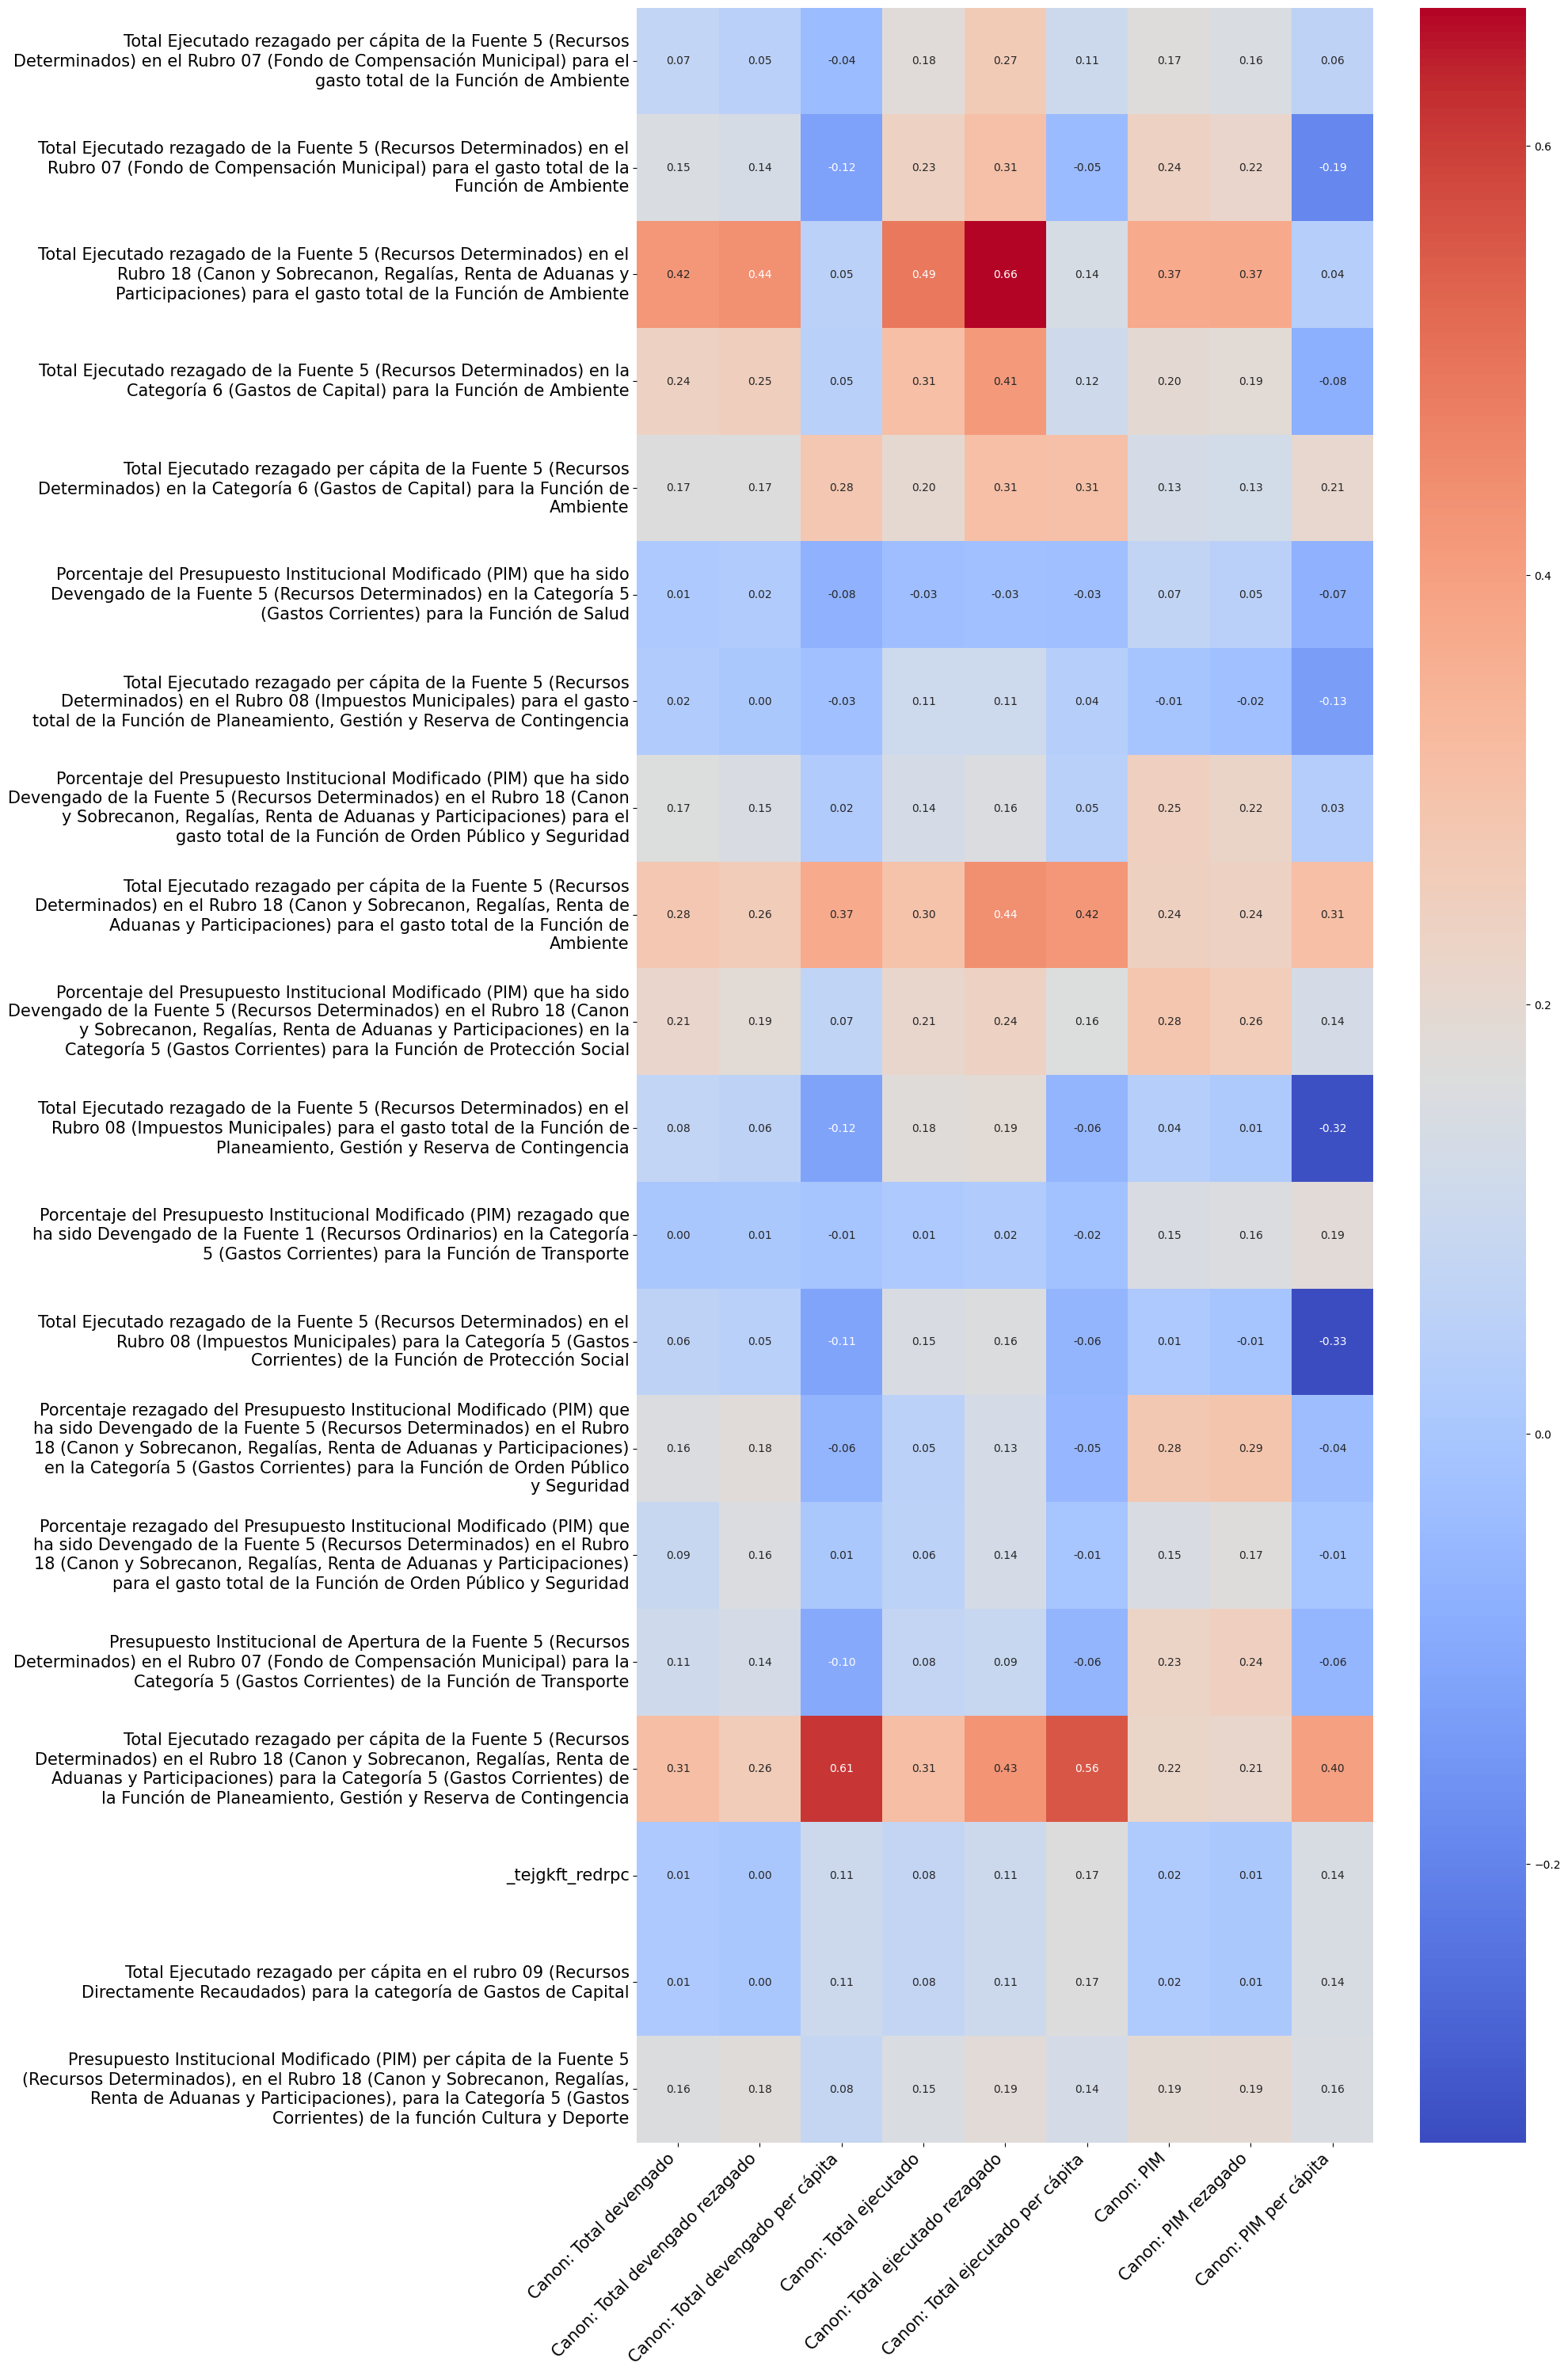

In [46]:
# Asumiendo que data es tu DataFrame y que has definido most_important_vars_ci y canon_vars
df_subset = data[most_important_vars_ci + canon_vars]
correlation_matrix = df_subset.corr()
correlation_matrix_subset = correlation_matrix.loc[most_important_vars_ci, canon_vars]

# Envolver (wrap) los nombres de las variables
wrapped_most_important_vars_ci = [textwrap.fill(name, width=70) for name in most_important_vars_ci]
wrapped_canon_vars = [textwrap.fill(name, width=50) for name in canon_vars]

plt.figure(figsize=(15, 35))
sns.heatmap(correlation_matrix_subset, annot=True, cmap='coolwarm', fmt=".2f",
            xticklabels=wrapped_canon_vars,
            yticklabels=wrapped_most_important_vars_ci)
# plt.title('Correlación entre las 20 primeras variables y las variables de Canon (Gini)', fontsize=18, fontweight='bold')

# Rotar las etiquetas si es necesario
plt.xticks(rotation=45, ha='right', fontsize=15)
plt.yticks(rotation=0, fontsize=15)

plt.savefig(f'../../../output/ejecucion_8/plots/ci_correlation_matrix_gini.jpg',
            format='jpg', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

### 2.1.2. Correlation by SHAP Values

In [47]:
# Definiendo el mapeo de nombres originales a etiquetas para las tres variables
variable_labels = {
    "pimgct_r13gstcrpc": "Presupuesto Institucional Modificado (PIM) per cápita en el Rubro 13 (Donaciones y Transferencias) para la Categoría de Gastos Corrientes",
    "pimgge_r13ct05biserpc": "Presupuesto Institucional Modificado (PIM) per cápita para la genérica 'Bienes y Servicios' en el Rubro 13 (Donaciones y Transferencias) de la Categoría 5 (Gastos Corrientes)",
    "_tejgfun_f5r18ct05pgrco": "Total Ejecutado rezagado de la Función Planeamiento, Gestión y Reserva de Contingencia, financiado por la Fuente 5 (Recursos Determinados), en el Rubro 18 (Canon y Sobrecanon, Regalías, Renta de Aduanas y Participaciones), para la Categoría 5 (Gastos Corrientes)"
}

# Renombrando solo las columnas que están en el mapeo
data = data.rename(columns={var: variable_labels[var] for var in data.columns if var in variable_labels})

most_important_vars_ci_shap = [
    "Total Ejecutado rezagado per cápita de la Fuente 5 (Recursos Determinados) en el Rubro 07 (Fondo de Compensación Municipal) para el gasto total de la Función de Ambiente",
    "Total Ejecutado rezagado de la Fuente 5 (Recursos Determinados) en el Rubro 07 (Fondo de Compensación Municipal) para el gasto total de la Función de Ambiente",
    "Total Ejecutado rezagado de la Fuente 5 (Recursos Determinados) en el Rubro 18 (Canon y Sobrecanon, Regalías, Renta de Aduanas y Participaciones) para el gasto total de la Función de Ambiente",
    "Total Ejecutado rezagado per cápita de la Fuente 5 (Recursos Determinados) en la Categoría 6 (Gastos de Capital) para la Función de Ambiente",
    "Porcentaje del Presupuesto Institucional Modificado (PIM) que ha sido Devengado de la Fuente 5 (Recursos Determinados) en la Categoría 5 (Gastos Corrientes) para la Función de Salud",
    "Total Ejecutado rezagado de la Fuente 5 (Recursos Determinados) en la Categoría 6 (Gastos de Capital) para la Función de Ambiente",
    "Total Ejecutado rezagado per cápita de la Fuente 5 (Recursos Determinados) en el Rubro 08 (Impuestos Municipales) para el gasto total de la Función de Planeamiento, Gestión y Reserva de Contingencia",
    "Total Ejecutado rezagado per cápita de la Fuente 5 (Recursos Determinados) en el Rubro 18 (Canon y Sobrecanon, Regalías, Renta de Aduanas y Participaciones) para el gasto total de la Función de Ambiente",
    "Total Ejecutado rezagado de la Fuente 5 (Recursos Determinados) en el Rubro 08 (Impuestos Municipales) para el gasto total de la Función de Planeamiento, Gestión y Reserva de Contingencia",
    "Porcentaje del Presupuesto Institucional Modificado (PIM) que ha sido Devengado de la Fuente 5 (Recursos Determinados) en el Rubro 18 (Canon y Sobrecanon, Regalías, Renta de Aduanas y Participaciones) para el gasto total de la Función de Orden Público y Seguridad",
    "Total Ejecutado rezagado de la Fuente 5 (Recursos Determinados) en el Rubro 08 (Impuestos Municipales) para la Categoría 5 (Gastos Corrientes) de la Función de Protección Social",
    "Presupuesto Institucional Modificado (PIM) per cápita de la Fuente 5 (Recursos Determinados), en el Rubro 18 (Canon y Sobrecanon, Regalías, Renta de Aduanas y Participaciones), para la Categoría 5 (Gastos Corrientes) de la función Cultura y Deporte",
    "Porcentaje del Presupuesto Institucional Modificado (PIM) que ha sido Devengado de la Fuente 5 (Recursos Determinados) en el Rubro 18 (Canon y Sobrecanon, Regalías, Renta de Aduanas y Participaciones) en la Categoría 5 (Gastos Corrientes) para la Función de Protección Social",
    "Porcentaje del Presupuesto Institucional Modificado (PIM) rezagado que ha sido Devengado de la Fuente 1 (Recursos Ordinarios) en la Categoría 5 (Gastos Corrientes) para la Función de Transporte",
    "Presupuesto Institucional Modificado (PIM) per cápita en el Rubro 13 (Donaciones y Transferencias) para la Categoría de Gastos Corrientes",
    "Total Ejecutado rezagado per cápita de la Fuente 5 (Recursos Determinados) en el Rubro 18 (Canon y Sobrecanon, Regalías, Renta de Aduanas y Participaciones) para la Categoría 5 (Gastos Corrientes) de la Función de Planeamiento, Gestión y Reserva de Contingencia",
    "Presupuesto Institucional Modificado (PIM) per cápita para la genérica 'Bienes y Servicios' en el Rubro 13 (Donaciones y Transferencias) de la Categoría 5 (Gastos Corrientes)",
    "_tejgkft_redrpc",
    "Total Ejecutado rezagado de la Función Planeamiento, Gestión y Reserva de Contingencia, financiado por la Fuente 5 (Recursos Determinados), en el Rubro 18 (Canon y Sobrecanon, Regalías, Renta de Aduanas y Participaciones), para la Categoría 5 (Gastos Corrientes)",
    "Porcentaje rezagado del Presupuesto Institucional Modificado (PIM) que ha sido Devengado de la Fuente 5 (Recursos Determinados) en el Rubro 18 (Canon y Sobrecanon, Regalías, Renta de Aduanas y Participaciones) en la Categoría 5 (Gastos Corrientes) para la Función de Orden Público y Seguridad"
]

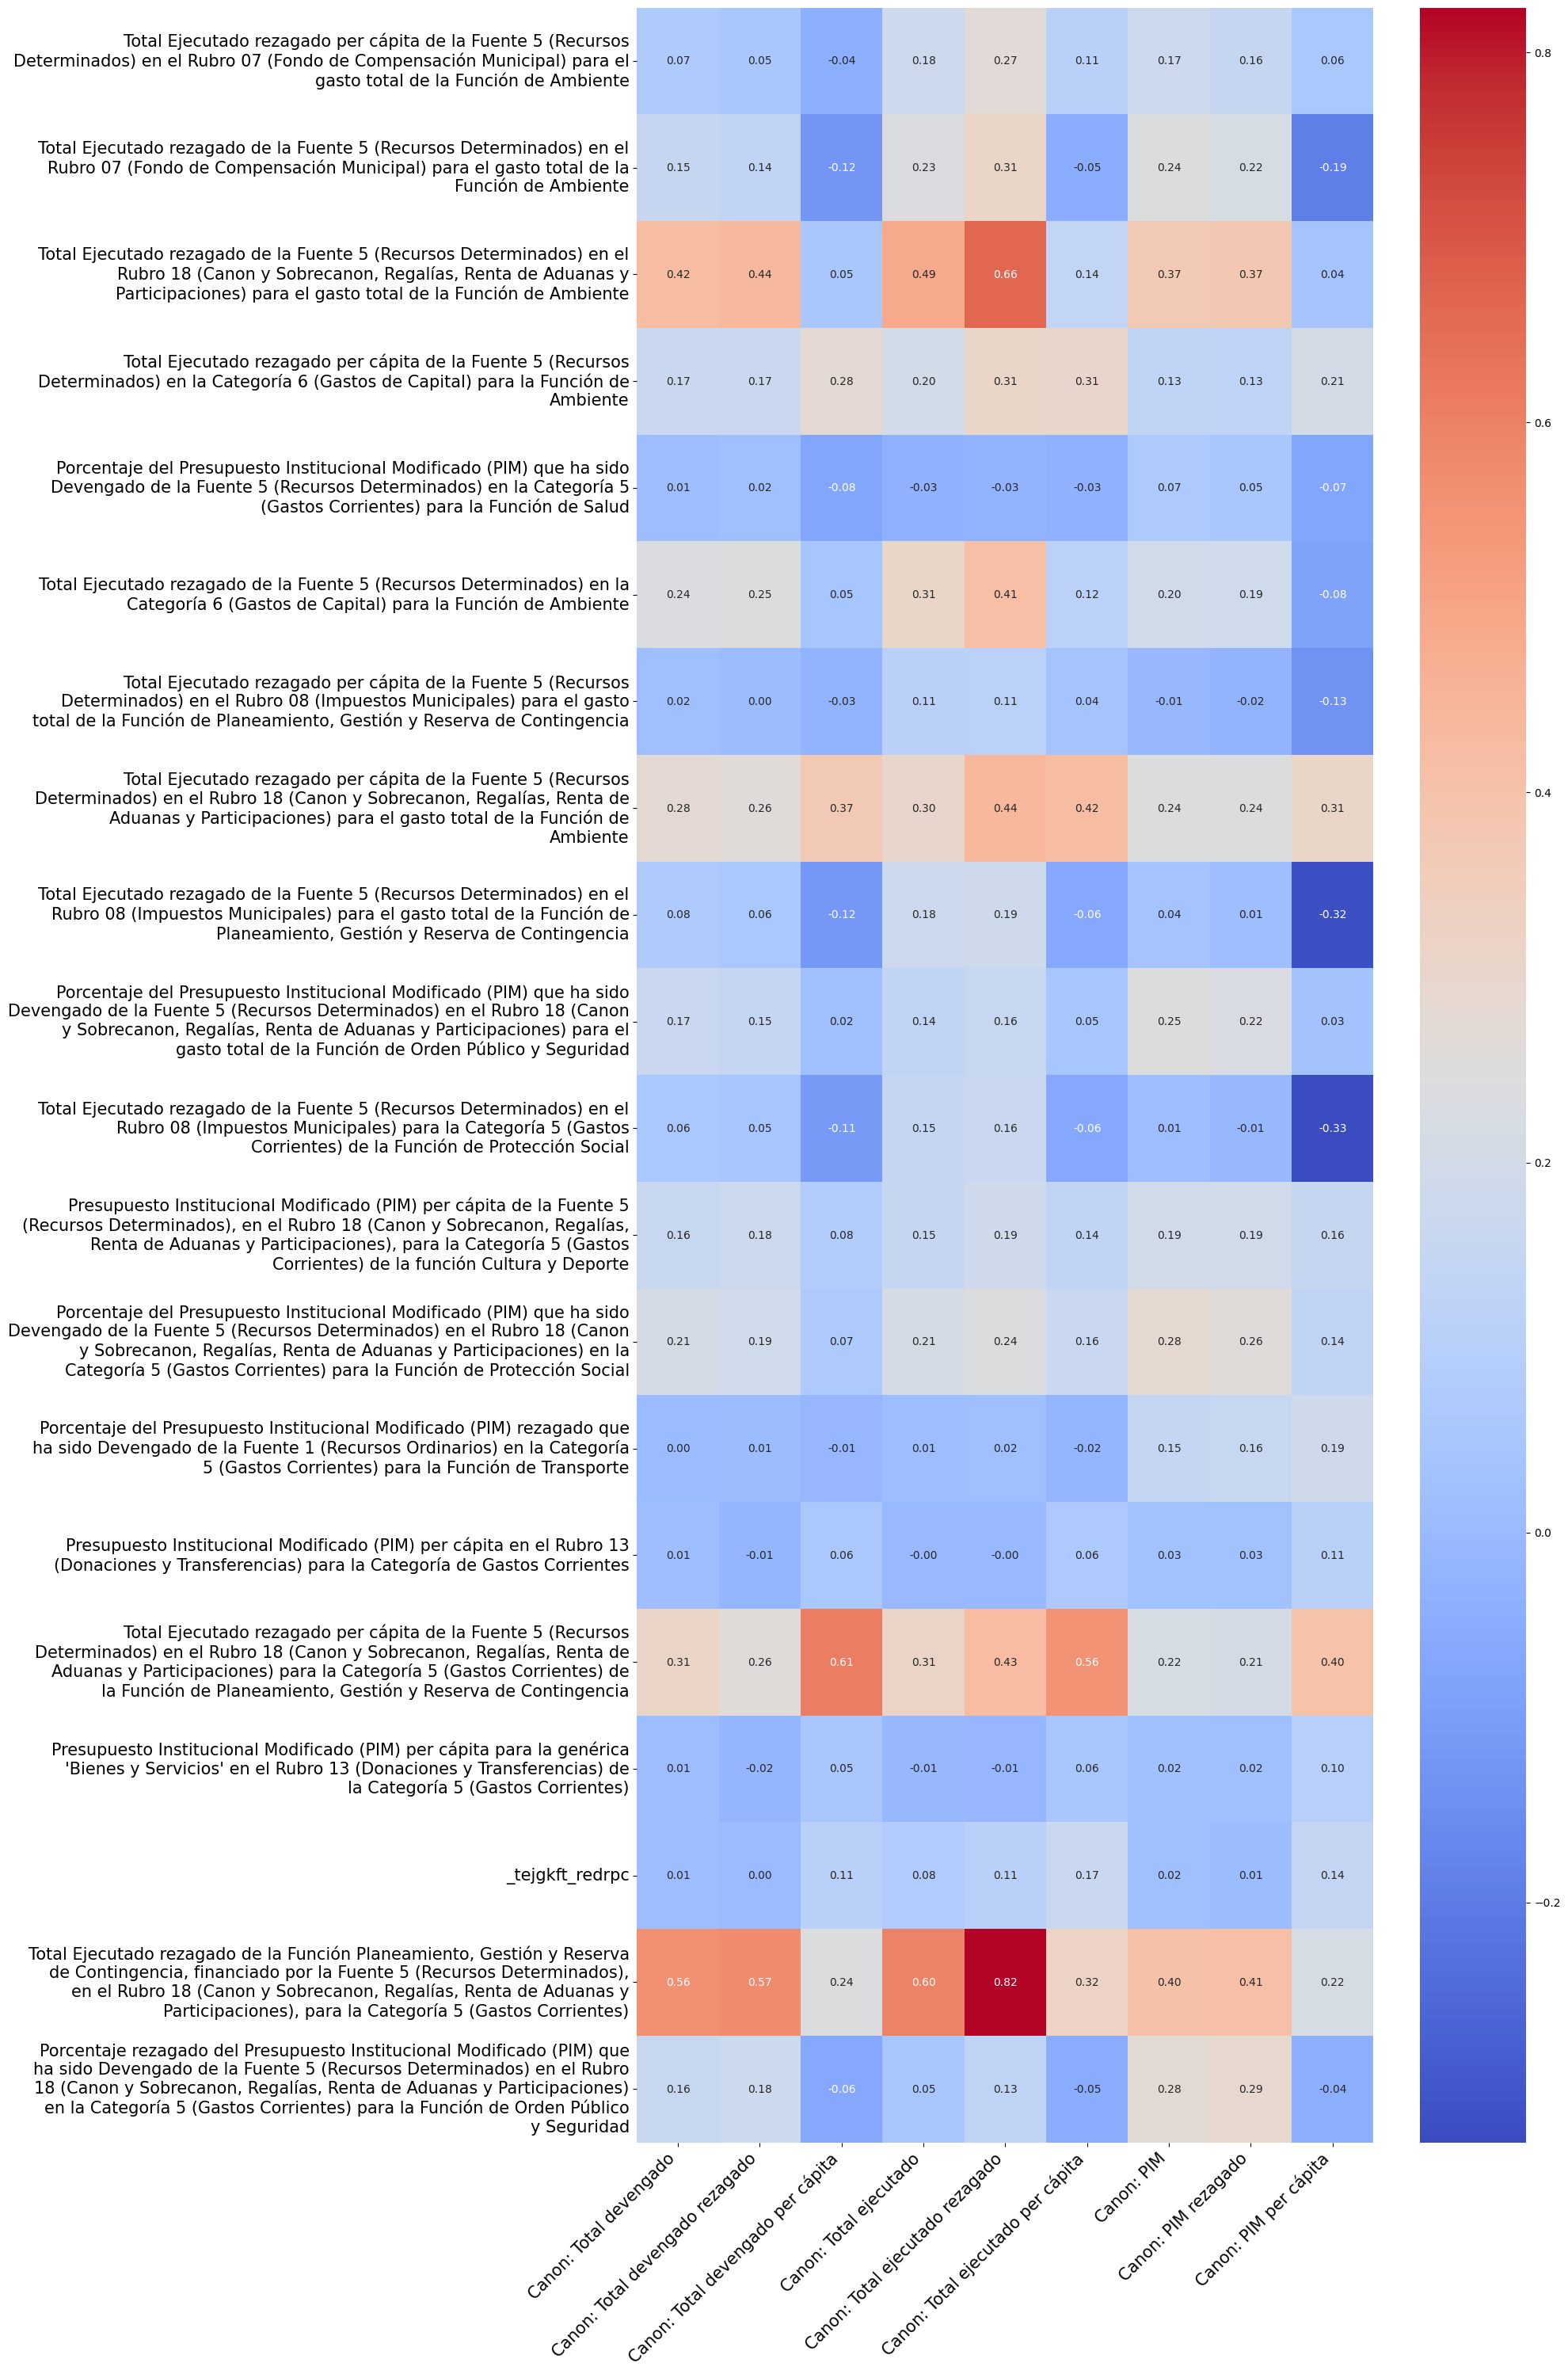

In [48]:
# Asumiendo que data es tu DataFrame y que has definido most_important_vars_ci y canon_vars
df_subset = data[most_important_vars_ci_shap + canon_vars]
correlation_matrix = df_subset.corr()
correlation_matrix_subset = correlation_matrix.loc[most_important_vars_ci_shap, canon_vars]

# Envolver (wrap) los nombres de las variables
wrapped_most_important_vars_ci_shap = [textwrap.fill(name, width=70) for name in most_important_vars_ci_shap]
wrapped_canon_vars = [textwrap.fill(name, width=50) for name in canon_vars]

plt.figure(figsize=(15, 35))
sns.heatmap(correlation_matrix_subset, annot=True, cmap='coolwarm', fmt=".2f",
            xticklabels=wrapped_canon_vars,
            yticklabels=wrapped_most_important_vars_ci_shap)
# plt.title('Correlación entre las 20 primeras variables y las variables de Canon (Gini)', fontsize=18, fontweight='bold')

# Rotar las etiquetas si es necesario
plt.xticks(rotation=45, ha='right', fontsize=15)
plt.yticks(rotation=0, fontsize=15)

plt.savefig(f'../../../output/ejecucion_8/plots/ci_correlation_matrix_shap.jpg',
            format='jpg', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

# 2.2. BROAD CORRUPTION

### 2.2.1. Gini Criteria

In [98]:
path = r'..\..\..\input\preprocessed_data\base0_siaf_canon_1620.csv'
data = pd.read_csv( path )

In [99]:
data = data.rename( columns = { 'totaldev_canon'  : 'Canon: Total devengado', 
                                '_totaldev_canon' : 'Canon: Total devengado rezagado',
                                'totaldev_canonpc': 'Canon: Total devengado per cápita',
                                'totaleje_canon'  : 'Canon: Total ejecutado',
                                '_totaleje_canon' : 'Canon: Total ejecutado rezagado',
                                'totaleje_canonpc': 'Canon: Total ejecutado per cápita',
                                'pim_canon'       : 'Canon: PIM',
                                '_pim_canon': 'Canon: PIM rezagado',
                                'pim_canonpc': 'Canon: PIM per cápita' } )


variable_labels = {
    "_devppimtotfun_f2cydeppc": "Porcentaje Devengado rezagado per cápita del PIM de la Fuente 2 (Recursos Directamente Recaudados) para el gasto total de la Función 21, que corresponde a Cultura y Deporte",
    "tejgtotfun_f5viv": "Total Ejecutado de la Fuente 5 (Recursos Determinados) para el gasto total de la Función 19 (Vivienda y Desarrollo Urbano)",
    "tejgfun_f5ct05pgrco": "Total Ejecutado de la Fuente 5 (Recursos Determinados) en la Categoría 5 (Gastos Corrientes) para la Función 03 (Planeamiento, Gestión y Reserva de Contingencia)",
    "tejgfun_f5ct05viv": "Total Ejecutado de la Fuente 5 (Recursos Determinados) en la Categoría 5 (Gastos Corrientes) para la Función 19 (Vivienda y Desarrollo Urbano)",
    "tejgfun_f5r08ct05prots": "Total Ejecutado de la Fuente 5 (Recursos Determinados) en el Rubro 08 (Impuestos Municipales), Categoría 5 (Gastos Corrientes) para la Función 23 (Protección Social)",
    "tejgfun_f5r18ct05vivpc": "Total Ejecutado per cápita de la Fuente 5 (Recursos Determinados) en el Rubro 18 (Canon y Sobrecanon, Regalías, Renta de Aduanas y Participaciones), Categoría 5 (Gastos Corrientes) para la Función 19 (Vivienda y Desarrollo Urbano)",
    "_tejgtotfun_f5viv": "Total Ejecutado rezagado de la Fuente 5 (Recursos Determinados) para el gasto total de la Función 19 (Vivienda y Desarrollo Urbano)",
    "_tejgfun_f2ct05opsegpc": "Total Ejecutado rezagado per cápita de la Fuente 2 (Recursos Directamente Recaudados) en la Categoría 5 (Gastos Corrientes) para la Función 05 (Orden Público y Seguridad)",
    "_piagfun_f2ct05opsegpc": "Presupuesto Institucional de Apertura rezagado per cápita de la Fuente 2 (Recursos Directamente Recaudados) en la Categoría 5 (Gastos Corrientes) para la Función 05 (Orden Público y Seguridad)",
    "tejgge_r09ct05otgst": "Total Ejecutado en el Rubro 09 (Recursos Directamente Recaudados), Categoría 5 (Gastos Corrientes), para la genérica de Otros Gastos",
    "tejgtotfun_f5r08prots": "Total Ejecutado de la Fuente 5 (Recursos Determinados), Rubro 08 (Impuestos Municipales) para la Función 23 (Protección Social)",
    "tejgrb_impm": "Total Ejecutado en el Rubro de Impuestos Municipales",
    "tejgfun_f5r08ct05protspc": "Total Ejecutado per cápita de la Fuente 5 (Recursos Determinados), en el Rubro 08 (Impuestos Municipales), Categoría 5 (Gastos Corrientes) para la Función 23 (Protección Social)",
    "_tejgge_r08ct05popso": "Total Ejecutado rezagado en el Rubro 08 (Impuestos Municipales), Categoría 5 (Gastos Corrientes), para la genérica 2 (Pensiones y Otras Prestaciones Sociales)",
    "tejgfun_f5ct05vivpc": "Total Ejecutado per cápita de la Fuente 5 (Recursos Determinados), en la Categoría 5 (Gastos Corrientes) para la Función 19 (Vivienda y Desarrollo Urbano)",
    "tejgrb_impmpc": "Total Ejecutado per cápita en el Rubro de Impuestos Municipales",
    "_tejgge_r09ct05biser": "Total Ejecutado rezagado en el Rubro 09 (Recursos Directamente Recaudados), Categoría 5 (Gastos Corrientes), para la genérica de Bienes y Servicios",
    "tejgfun_f2ct05ambpc": "Total Ejecutado de la Fuente 2 (Recursos Directamente Recaudados), en la Categoría 5 (Gastos Corrientes) para la Función 17 (Ambiente)",
    "tejgfun_f5ct06viv": "Total Ejecutado de la Fuente 5 (Recursos Determinados), en la Categoría 6 (Gastos de Capital) para la Función 19 (Vivienda y Desarrollo Urbano)",
    "tejgtotfun_f5pgrco": "Total Ejecutado de la Fuente 5 (Recursos Determinados) para el gasto total de la Función 03 (Planeamiento, Gestión y Reserva de Contingencia)"
}


most_important_vars_ca = [
    "Porcentaje Devengado rezagado per cápita del PIM de la Fuente 2 (Recursos Directamente Recaudados) para el gasto total de la Función 21, que corresponde a Cultura y Deporte",
    "Total Ejecutado de la Fuente 5 (Recursos Determinados) para el gasto total de la Función 19 (Vivienda y Desarrollo Urbano)",
    "Total Ejecutado de la Fuente 5 (Recursos Determinados) en la Categoría 5 (Gastos Corrientes) para la Función 03 (Planeamiento, Gestión y Reserva de Contingencia)",
    "Total Ejecutado de la Fuente 5 (Recursos Determinados) en la Categoría 5 (Gastos Corrientes) para la Función 19 (Vivienda y Desarrollo Urbano)",
    "Total Ejecutado de la Fuente 5 (Recursos Determinados) en el Rubro 08 (Impuestos Municipales), Categoría 5 (Gastos Corrientes) para la Función 23 (Protección Social)",
    "Total Ejecutado per cápita de la Fuente 5 (Recursos Determinados) en el Rubro 18 (Canon y Sobrecanon, Regalías, Renta de Aduanas y Participaciones), Categoría 5 (Gastos Corrientes) para la Función 19 (Vivienda y Desarrollo Urbano)",
    "Total Ejecutado rezagado de la Fuente 5 (Recursos Determinados) para el gasto total de la Función 19 (Vivienda y Desarrollo Urbano)",
    "Total Ejecutado rezagado per cápita de la Fuente 2 (Recursos Directamente Recaudados) en la Categoría 5 (Gastos Corrientes) para la Función 05 (Orden Público y Seguridad)",
    "Presupuesto Institucional de Apertura rezagado per cápita de la Fuente 2 (Recursos Directamente Recaudados) en la Categoría 5 (Gastos Corrientes) para la Función 05 (Orden Público y Seguridad)",
    "Total Ejecutado en el Rubro 09 (Recursos Directamente Recaudados), Categoría 5 (Gastos Corrientes), para la genérica de Otros Gastos",
    "Total Ejecutado de la Fuente 5 (Recursos Determinados), Rubro 08 (Impuestos Municipales) para la Función 23 (Protección Social)",
    "Total Ejecutado en el Rubro de Impuestos Municipales",
    "Total Ejecutado per cápita de la Fuente 5 (Recursos Determinados), en el Rubro 08 (Impuestos Municipales), Categoría 5 (Gastos Corrientes) para la Función 23 (Protección Social)",
    "Total Ejecutado rezagado en el Rubro 08 (Impuestos Municipales), Categoría 5 (Gastos Corrientes), para la genérica 2 (Pensiones y Otras Prestaciones Sociales)",
    "Total Ejecutado per cápita de la Fuente 5 (Recursos Determinados), en la Categoría 5 (Gastos Corrientes) para la Función 19 (Vivienda y Desarrollo Urbano)",
    "Total Ejecutado per cápita en el Rubro de Impuestos Municipales",
    "Total Ejecutado rezagado en el Rubro 09 (Recursos Directamente Recaudados), Categoría 5 (Gastos Corrientes), para la genérica de Bienes y Servicios",
    "Total Ejecutado de la Fuente 2 (Recursos Directamente Recaudados), en la Categoría 5 (Gastos Corrientes) para la Función 17 (Ambiente)",
    "Total Ejecutado de la Fuente 5 (Recursos Determinados), en la Categoría 6 (Gastos de Capital) para la Función 19 (Vivienda y Desarrollo Urbano)",
    "Total Ejecutado de la Fuente 5 (Recursos Determinados) para el gasto total de la Función 03 (Planeamiento, Gestión y Reserva de Contingencia)"
]

data = data.rename(columns={var: variable_labels[var] for var in data.columns if var in variable_labels})

canon_vars          = [ 'Canon: Total devengado', 'Canon: Total devengado rezagado', 'Canon: Total devengado per cápita', 
                        'Canon: Total ejecutado', 'Canon: Total ejecutado rezagado', 'Canon: Total ejecutado per cápita',
                        'Canon: PIM', 'Canon: PIM rezagado', 'Canon: PIM per cápita' ]

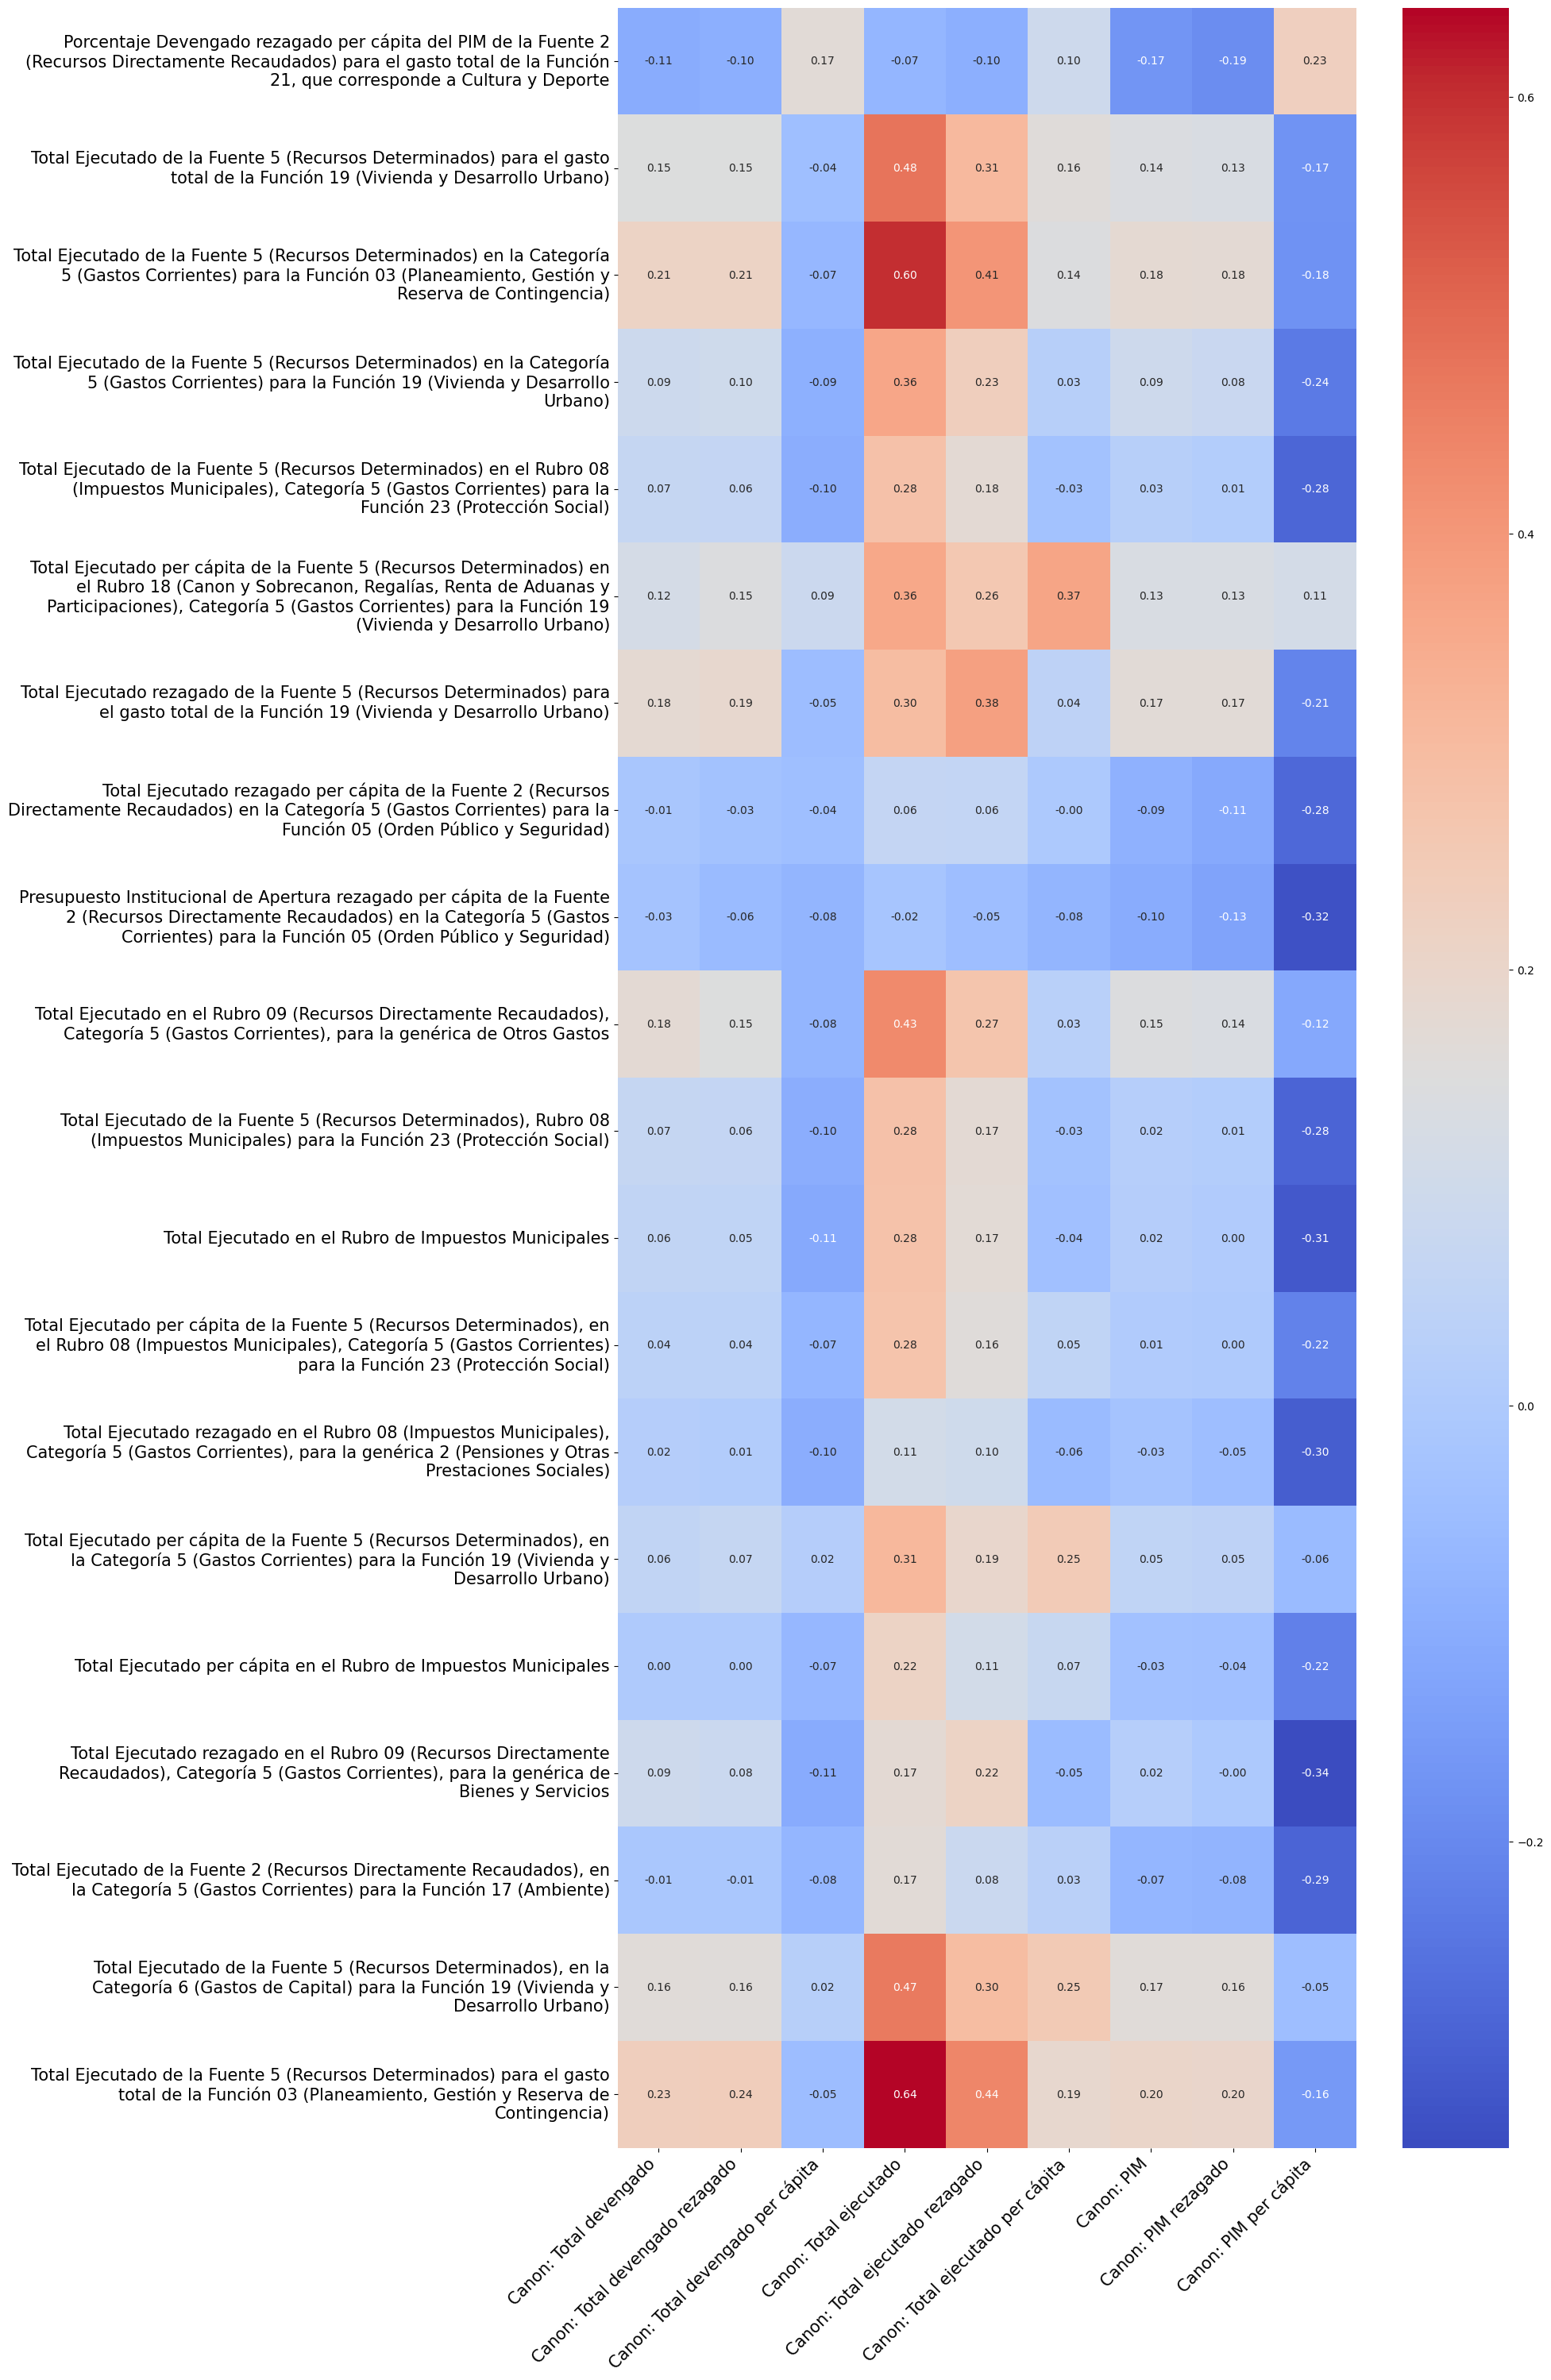

In [92]:
# Asumiendo que data es tu DataFrame y que has definido most_important_vars_ca y canon_vars
df_subset = data[most_important_vars_ca + canon_vars]
correlation_matrix = df_subset.corr()
correlation_matrix_subset = correlation_matrix.loc[most_important_vars_ca, canon_vars]

# Envolver (wrap) los nombres de las variables
wrapped_most_important_vars_ca = [textwrap.fill(name, width=70) for name in most_important_vars_ca]
wrapped_canon_vars = [textwrap.fill(name, width=50) for name in canon_vars]

plt.figure(figsize=(15, 35))
sns.heatmap(correlation_matrix_subset, annot=True, cmap='coolwarm', fmt=".2f",
            xticklabels=wrapped_canon_vars,
            yticklabels=wrapped_most_important_vars_ca)
# plt.title('Correlación entre las 20 primeras variables y las variables de Canon (Gini)', fontsize=18, fontweight='bold')

# Rotar las etiquetas si es necesario
plt.xticks(rotation=45, ha='right', fontsize=15)
plt.yticks(rotation=0, fontsize=15)

plt.savefig(f'../../../output/ejecucion_8/plots/ca_correlation_matrix_gini.jpg',
            format='jpg', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

### 2.2.2. Correlation by SHAP Values

In [103]:
path = r'..\..\..\input\preprocessed_data\base0_siaf_canon_1620.csv'
data = pd.read_csv( path )

In [105]:
data = data.rename( columns = { 'totaldev_canon'  : 'Canon: Total devengado', 
                                '_totaldev_canon' : 'Canon: Total devengado rezagado',
                                'totaldev_canonpc': 'Canon: Total devengado per cápita',
                                'totaleje_canon'  : 'Canon: Total ejecutado',
                                '_totaleje_canon' : 'Canon: Total ejecutado rezagado',
                                'totaleje_canonpc': 'Canon: Total ejecutado per cápita',
                                'pim_canon'       : 'Canon: PIM',
                                '_pim_canon': 'Canon: PIM rezagado',
                                'pim_canonpc': 'Canon: PIM per cápita' } )

# Definiendo el mapeo de nombres originales a etiquetas para las tres variables
variable_labels = {
    "_devppimtotfun_f2cydeppc": "Porcentaje Devengado rezagado per cápita del PIM de la Fuente 2 (Recursos Directamente Recaudados) para el gasto total de la Función 21 (Cultura y Deporte)",
    "tejgfun_f5ct05pgrco": "Total Ejecutado de la Fuente 5 (Recursos Determinados) en la Categoría 5 (Gastos Corrientes) para la Función 03 (Planeamiento, Gestión y Reserva de Contingencia)",
    "tejgtotfun_f5viv": "Total Ejecutado de la Fuente 5 (Recursos Determinados) para el gasto total de la Función 19 (Vivienda y Desarrollo Urbano)",
    "tejgfun_f5ct05viv": "Total Ejecutado de la Fuente 5 (Recursos Determinados) en la Categoría 5 (Gastos Corrientes) para la Función 19 (Vivienda y Desarrollo Urbano)",
    "tejgfun_f5r08ct05prots": "Total Ejecutado de la Fuente 5 (Recursos Determinados) en el Rubro 08 (Impuestos Municipales), Categoría 5 (Gastos Corrientes) para la Función 23 (Protección Social)",
    "_piagfun_f2ct05opsegpc": "Presupuesto Institucional de Apertura rezagado per cápita de la Fuente 2 (Recursos Directamente Recaudados) en la Categoría 5 (Gastos Corrientes) para la Función 05 (Orden Público y Seguridad)",
    "tejgfun_f5r18ct05vivpc": "Total Ejecutado per cápita de la Fuente 5 (Recursos Determinados) en el Rubro 18 (Canon y Sobrecanon, Regalías, Renta de Aduanas y Participaciones), Categoría 5 (Gastos Corrientes) para la Función 19 (Vivienda y Desarrollo Urbano)",
    "_tejgtotfun_f5viv": "Total Ejecutado rezagado de la Fuente 5 (Recursos Determinados) para el gasto total de la Función 19 (Vivienda y Desarrollo Urbano)",
    "tejgge_r09ct05otgst": "Total Ejecutado en el Rubro 09 (Recursos Directamente Recaudados), Categoría 5 (Gastos Corrientes), para la genérica de Otros Gastos.",
    "dfgpimpiatotfun_f5r08pgrco": "Diferencia entre el Presupuesto Institucional Modificado (PIM) y el Presupuesto Institucional de Apertura (PIA) de la Fuente 5 (Recursos Determinados) en el Rubro 08 (Impuestos Municipales) para la Función 03 (Planeamiento, Gestión y Reserva de Contingencia)",
    "_tejgfun_f2ct05opsegpc": "Total Ejecutado rezagado per cápita de la Fuente 2 (Recursos Directamente Recaudados) en la Categoría 5 (Gastos Corrientes) para la Función 05 (Orden Público y Seguridad)",
    "_devppimtotfun_f5trans": "Porcentaje Devengado del PIM rezagado de la Fuente 5 (Recursos Determinados) para el gasto total de la Función 15 (Transporte)",
    "_piagtotfun_f2opsegpc": "Presupuesto Institucional de Apertura (PIA) rezagado per cápita de la Fuente 2 (Recursos Directamente Recaudados) para el gasto total de la Función 05, que corresponde a Orden Público y Seguridad",
    "tejgtotfun_f5r08prots": "Total Ejecutado de la Fuente 5 (Recursos Determinados) en el Rubro 08 (Impuestos Municipales) para el gasto total de la Función 23 (Protección Social)",
    "tejgrb_impm": "Total Ejecutado en el Rubro de Impuestos Municipales",
    "_dfgdevpiagtotfun_f2opsegpc": "Diferencia entre el Total Devengado y el Presupuesto Institucional de Apertura (PIA) rezagado per cápita de la Fuente 2 (Recursos Directamente Recaudados) para el gasto total de la Función 05 (Orden Público y Seguridad)",
    "_piagtotfun_f5turi": "Presupuesto Institucional de Apertura (PIA) rezagado de la Fuente 5 (Recursos Determinados) para el gasto total de la Función 09 (Turismo)",
    "tejgfun_f5ct06viv": "Total Ejecutado de la Fuente 5 (Recursos Determinados) en la Categoría 6 (Gastos de Capital) para la Función 19 (Vivienda y Desarrollo Urbano)",
    "tejgrb_impmpc": "Total Ejecutado per cápita en el Rubro de Impuestos Municipales",
    "_tejgge_r09ct05biser": "Total Ejecutado rezagado en el Rubro 09 (Recursos Directamente Recaudados), Categoría 5 (Gastos Corrientes), para la Genérica de Bienes y Servicios",
}

# Renombrando solo las columnas que están en el mapeo
data = data.rename(columns={var: variable_labels[var] for var in data.columns if var in variable_labels})

most_important_vars_ca_shap = [
    "Porcentaje Devengado rezagado per cápita del PIM de la Fuente 2 (Recursos Directamente Recaudados) para el gasto total de la Función 21 (Cultura y Deporte)",
    "Total Ejecutado de la Fuente 5 (Recursos Determinados) en la Categoría 5 (Gastos Corrientes) para la Función 03 (Planeamiento, Gestión y Reserva de Contingencia)",
    "Total Ejecutado de la Fuente 5 (Recursos Determinados) para el gasto total de la Función 19 (Vivienda y Desarrollo Urbano)",
    "Total Ejecutado de la Fuente 5 (Recursos Determinados) en la Categoría 5 (Gastos Corrientes) para la Función 19 (Vivienda y Desarrollo Urbano)",
    "Total Ejecutado de la Fuente 5 (Recursos Determinados) en el Rubro 08 (Impuestos Municipales), Categoría 5 (Gastos Corrientes) para la Función 23 (Protección Social)",
    "Presupuesto Institucional de Apertura rezagado per cápita de la Fuente 2 (Recursos Directamente Recaudados) en la Categoría 5 (Gastos Corrientes) para la Función 05 (Orden Público y Seguridad)",
    "Total Ejecutado per cápita de la Fuente 5 (Recursos Determinados) en el Rubro 18 (Canon y Sobrecanon, Regalías, Renta de Aduanas y Participaciones), Categoría 5 (Gastos Corrientes) para la Función 19 (Vivienda y Desarrollo Urbano)",
    "Total Ejecutado rezagado de la Fuente 5 (Recursos Determinados) para el gasto total de la Función 19 (Vivienda y Desarrollo Urbano)",
    "Total Ejecutado en el Rubro 09 (Recursos Directamente Recaudados), Categoría 5 (Gastos Corrientes), para la genérica de Otros Gastos.",
    "Diferencia entre el Presupuesto Institucional Modificado (PIM) y el Presupuesto Institucional de Apertura (PIA) de la Fuente 5 (Recursos Determinados) en el Rubro 08 (Impuestos Municipales) para la Función 03 (Planeamiento, Gestión y Reserva de Contingencia)",
    "Total Ejecutado rezagado per cápita de la Fuente 2 (Recursos Directamente Recaudados) en la Categoría 5 (Gastos Corrientes) para la Función 05 (Orden Público y Seguridad)",
    "Porcentaje Devengado del PIM rezagado de la Fuente 5 (Recursos Determinados) para el gasto total de la Función 15 (Transporte)",
    "Presupuesto Institucional de Apertura (PIA) rezagado per cápita de la Fuente 2 (Recursos Directamente Recaudados) para el gasto total de la Función 05, que corresponde a Orden Público y Seguridad",
    "Total Ejecutado de la Fuente 5 (Recursos Determinados) en el Rubro 08 (Impuestos Municipales) para el gasto total de la Función 23 (Protección Social)",
    "Total Ejecutado en el Rubro de Impuestos Municipales",
    "Diferencia entre el Total Devengado y el Presupuesto Institucional de Apertura (PIA) rezagado per cápita de la Fuente 2 (Recursos Directamente Recaudados) para el gasto total de la Función 05 (Orden Público y Seguridad)",
    "Presupuesto Institucional de Apertura (PIA) rezagado de la Fuente 5 (Recursos Determinados) para el gasto total de la Función 09 (Turismo)",
    "Total Ejecutado de la Fuente 5 (Recursos Determinados) en la Categoría 6 (Gastos de Capital) para la Función 19 (Vivienda y Desarrollo Urbano)",
    "Total Ejecutado per cápita en el Rubro de Impuestos Municipales",
    "Total Ejecutado rezagado en el Rubro 09 (Recursos Directamente Recaudados), Categoría 5 (Gastos Corrientes), para la Genérica de Bienes y Servicios"
]

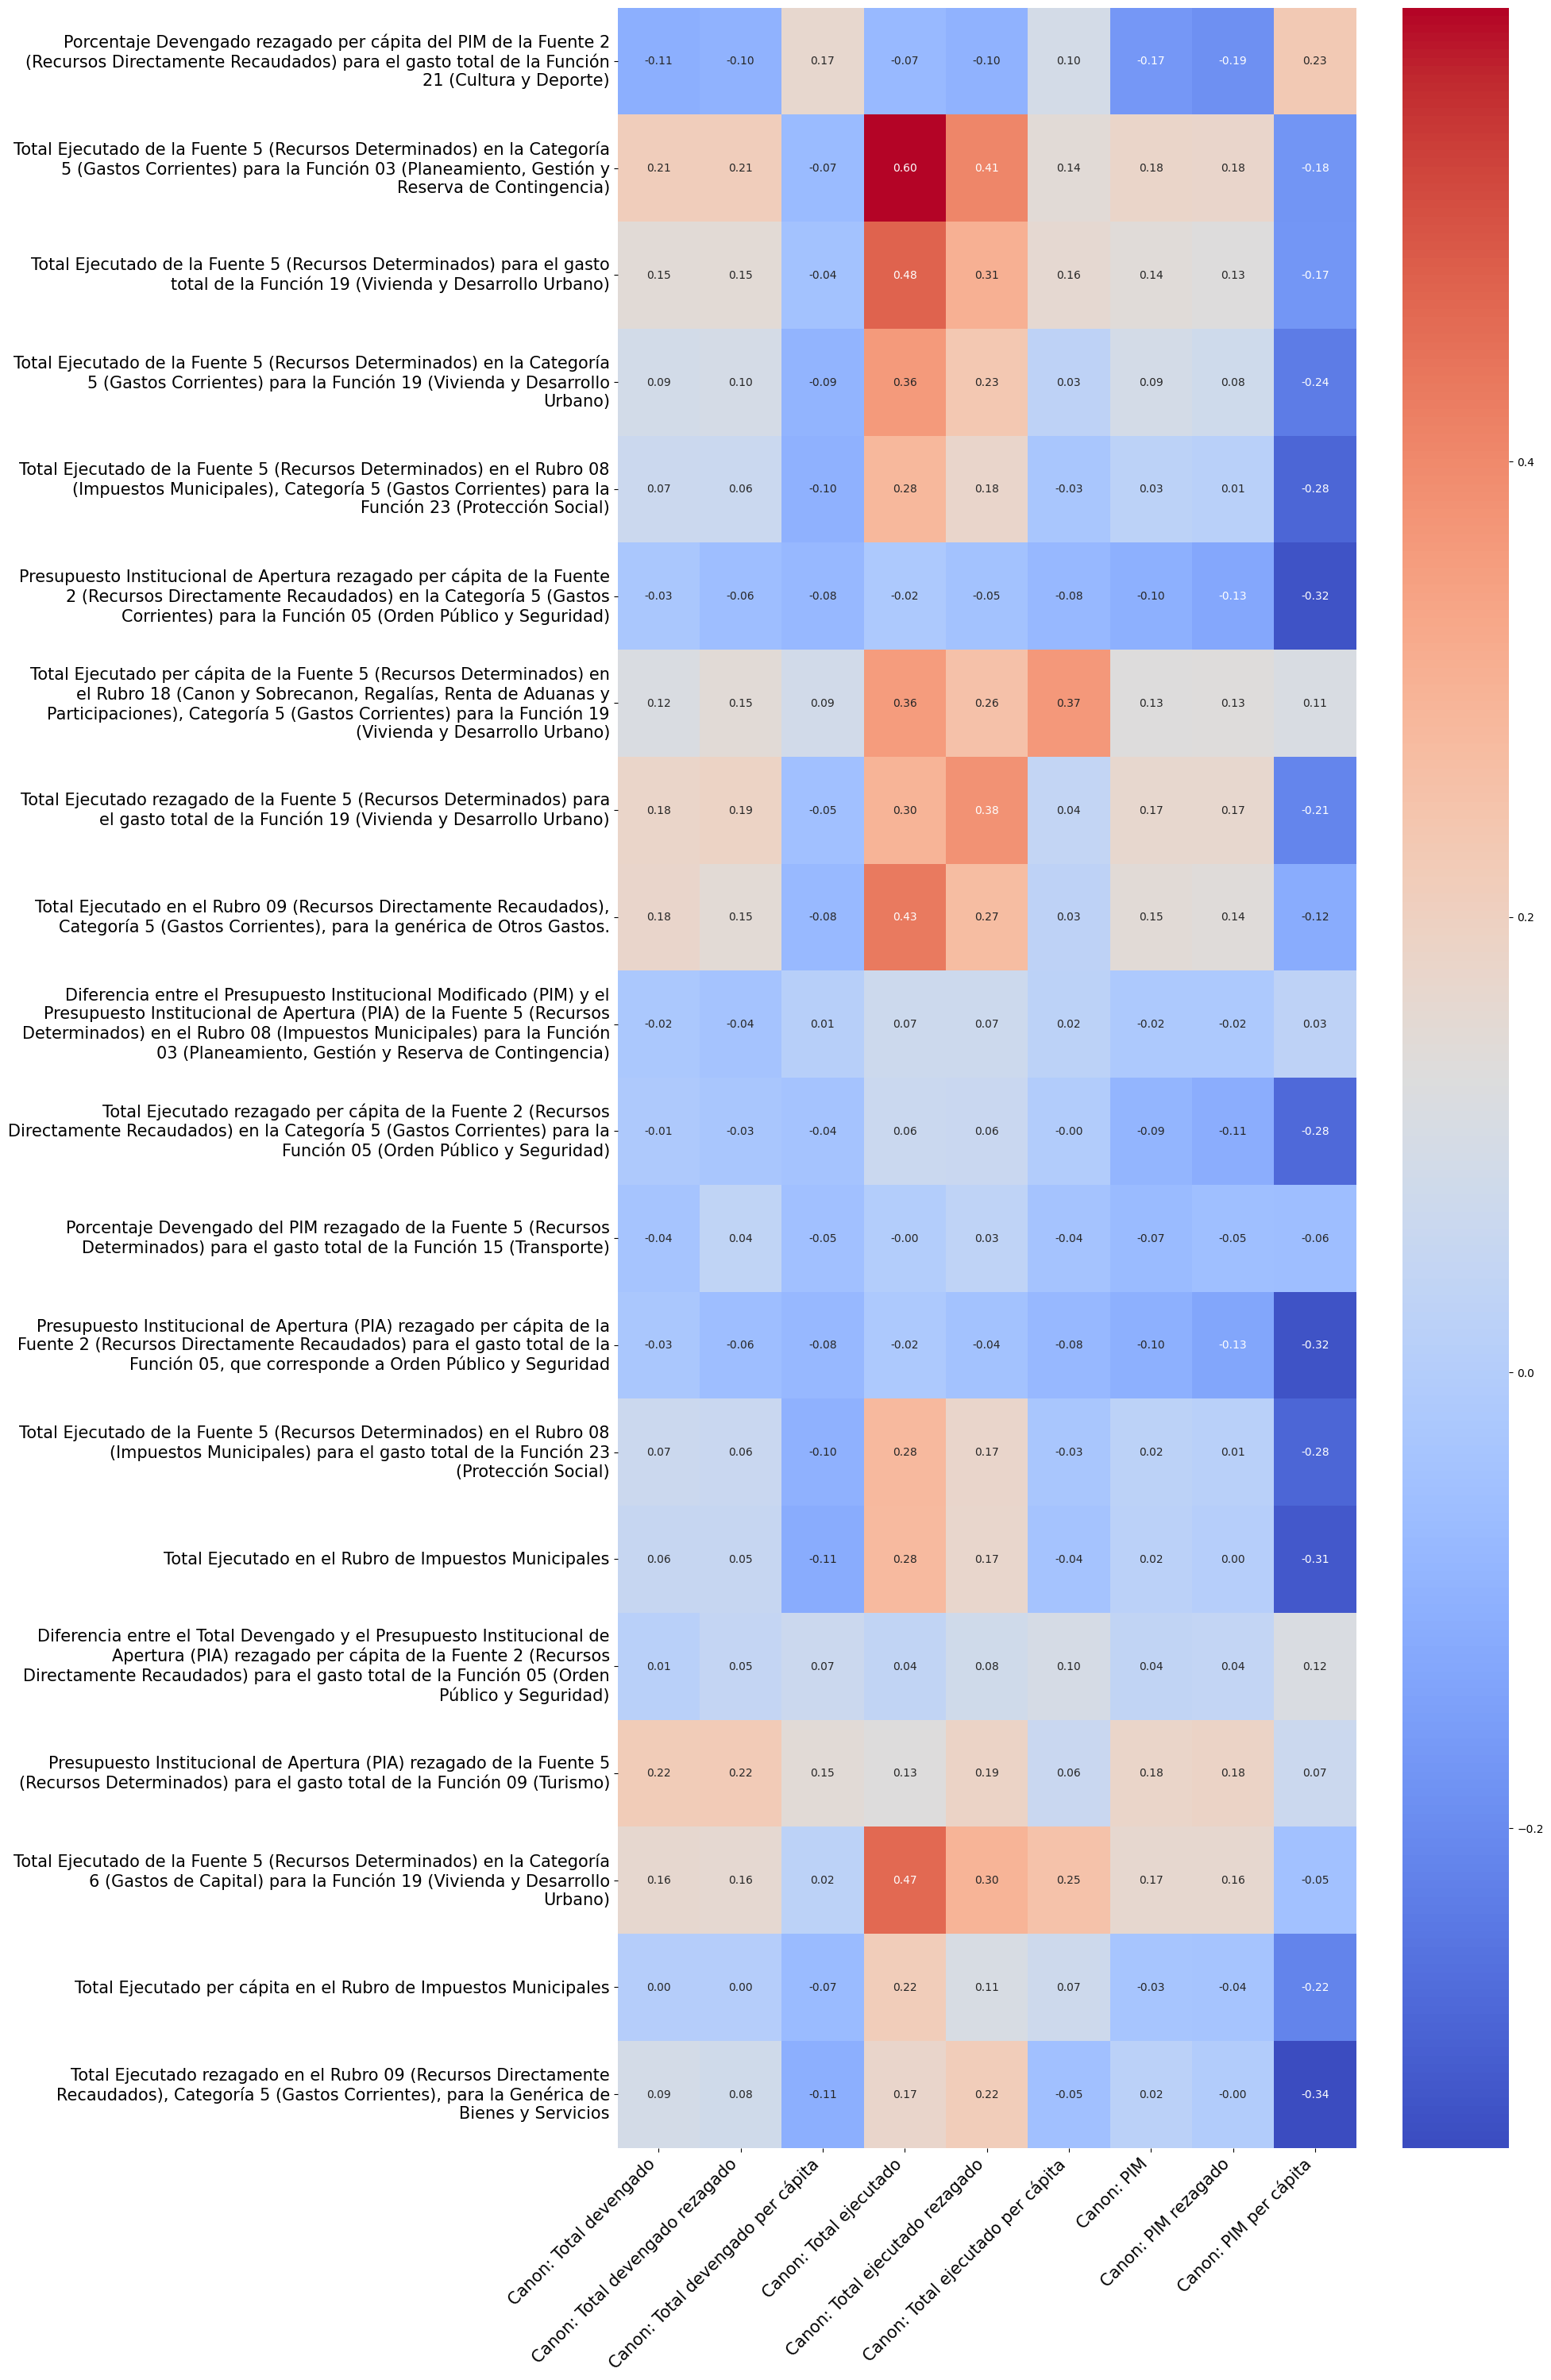

In [106]:
# Asumiendo que data es tu DataFrame y que has definido most_important_vars_ca_shap y canon_vars
df_subset = data[most_important_vars_ca_shap + canon_vars]
correlation_matrix = df_subset.corr()
correlation_matrix_subset = correlation_matrix.loc[most_important_vars_ca_shap, canon_vars]

# Envolver (wrap) los nombres de las variables
wrapped_most_important_vars_ca_shap = [textwrap.fill(name, width=70) for name in most_important_vars_ca_shap]
wrapped_canon_vars = [textwrap.fill(name, width=50) for name in canon_vars]

plt.figure(figsize=(15, 35))
sns.heatmap(correlation_matrix_subset, annot=True, cmap='coolwarm', fmt=".2f",
            xticklabels=wrapped_canon_vars,
            yticklabels=wrapped_most_important_vars_ca_shap)
# plt.title('Correlación entre las 20 primeras variables y las variables de Canon (Gini)', fontsize=18, fontweight='bold')

# Rotar las etiquetas si es necesario
plt.xticks(rotation=45, ha='right', fontsize=15)
plt.yticks(rotation=0, fontsize=15)

plt.savefig(f'../../../output/ejecucion_8/plots/ca_correlation_matrix_shap.jpg',
            format='jpg', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

# 3. SHAP Values

### 3.1. Intense Corruption

In [49]:
path = r'..\..\..\input\preprocessed_data\base0_siaf_canon_1620.csv'
data = pd.read_csv( path )

In [50]:
dep_var    = [ 'corrup_intensa' ]
other_vars = [ 'monto_examinado', 'monto_auditado', 'monto_objeto_servicio',
               'monto_corrup1', 'monto_corrup2', 'tipo_control', 'corrup_amplia',
               'per_corrup1', 'per_corrup2', '_monto', 'monto_', 'year', 'ubigeo' ]

pred_vars  = [ col for col in data.columns if col not in dep_var and col not in other_vars ]

x_train, x_test, y_train, y_test = train_test_split( data[ pred_vars ],
                                                     data[ 'corrup_intensa' ],
                                                     test_size    = 0.3,
                                                     random_state = 2023,
                                                     stratify = data[ 'corrup_intensa' ] )

In [51]:
path         = r'..\..\..\output\ejecucion_8\models\model_ci_Random Forest Classifier_st.joblib'
loaded_model = joblib.load( path )

In [52]:
x_train_s, x_train_st, x_train_nro, y_train_s, y_train_st, y_train_nro = fun.resampling( x_train, y_train )

In [53]:
explainer = shap.TreeExplainer(loaded_model)
shap_values = explainer.shap_values(x_train_st, approximate=False, check_additivity=False)

In [79]:
shap_sum = np.abs(shap_values[0]).mean(axis=0)
feature_importance_df = pd.DataFrame({
    'Feature': x_train_st.columns,
    'SHAP Value': shap_sum
})
feature_importance_df = feature_importance_df.sort_values(by='SHAP Value', ascending=False)
feature_importance_df.to_excel(r'..\..\..\output\ejecucion_8\vars\shap_varlist_ci_Random Forest Classifier_st.xlsx')

In [54]:
name_mapping = {
    "_tejgtotfun_f5r07ambpc": "Total Ejecutado rezagado per cápita de la Fuente 5 (Recursos Determinados) en el Rubro 07 (Fondo de Compensación Municipal) para el gasto total de la Función de Ambiente.",
    "_tejgtotfun_f5r07amb": "Total Ejecutado rezagado de la Fuente 5 (Recursos Determinados) en el Rubro 07 (Fondo de Compensación Municipal) para el gasto total de la Función de Ambiente.",
    "_tejgtotfun_f5r18amb": "Total Ejecutado rezagado de la Fuente 5 (Recursos Determinados) en el Rubro 18 (Canon y Sobrecanon, Regalías, Renta de Aduanas y Participaciones) para el gasto total de la Función de Ambiente",
    "_tejgfun_f5ct06ambpc": "Total Ejecutado rezagado per cápita de la Fuente 5 (Recursos Determinados) en la Categoría 6 (Gastos de Capital) para la Función de Ambiente.",
    "devppimfun_f5ct05salud": "Porcentaje del Presupuesto Institucional Modificado (PIM) que ha sido Devengado de la Fuente 5 (Recursos Determinados) en la Categoría 5 (Gastos Corrientes) para la Función de Salud.",
    "_tejgfun_f5ct06amb": "Total Ejecutado rezagado de la Fuente 5 (Recursos Determinados) en la Categoría 6 (Gastos de Capital) para la Función de Ambiente.",
    "_tejgtotfun_f5r08pgrcopc": "Total Ejecutado rezagado per cápita de la Fuente 5 (Recursos Determinados) en el Rubro 08 (Impuestos Municipales) para el gasto total de la Función de Planeamiento, Gestión y Reserva de Contingencia.",
    "_tejgtotfun_f5r18ambpc": "Total Ejecutado rezagado per cápita de la Fuente 5 (Recursos Determinados) en el Rubro 18 (Canon y Sobrecanon, Regalías, Renta de Aduanas y Participaciones) para el gasto total de la Función de Ambiente.",
    "_tejgtotfun_f5r08pgrco": "Total Ejecutado rezagadode la Fuente 5 (Recursos Determinados) en el Rubro 08 (Impuestos Municipales) para el gasto total de la Función de Planeamiento, Gestión y Reserva de Contingencia.",
    "devppimtotfun_f5r18opseg": "Porcentaje del Presupuesto Institucional Modificado (PIM) que ha sido Devengado de la Fuente 5 (Recursos Determinados) en el Rubro 18 (Canon y Sobrecanon, Regalías, Renta de Aduanas y Participaciones) para el gasto total de la Función de Orden Público y Seguridad.",
    "_tejgfun_f5r08ct05prots": "Total Ejecutado rezagado de la Fuente 5 (Recursos Determinados) en el Rubro 08 (Impuestos Municipales) para la Categoría 5 (Gastos Corrientes) de la Función de Protección Social",
    "pimgfun_f5r18ct05cydeppc": "Presupuesto Institucional Modificado (PIM) per cápita de la Fuente 5 (Recursos Determinados), en el Rubro 18 (Canon y Sobrecanon, Regalías, Renta de Aduanas y Participaciones), para la Categoría 5 (Gastos Corrientes) de la función Cultura y Deporte",
    "devppimfun_f5r18ct05prots": "Porcentaje del Presupuesto Institucional Modificado (PIM) que ha sido Devengado de la Fuente 5 (Recursos Determinados) en el Rubro 18 (Canon y Sobrecanon, Regalías, Renta de Aduanas y Participaciones) en la Categoría 5 (Gastos Corrientes) para la Función de Protección Social.",
    "_devppimfun_f1ct05trans": "Porcentaje del Presupuesto Institucional Modificado (PIM) rezagado que ha sido Devengado de la Fuente 1 (Recursos Ordinarios) en la Categoría 5 (Gastos Corrientes) para la Función de Transporte.",
    "pimgct_r13gstcrpc": "Presupuesto Institucional Modificado (PIM) per cápita en el Rubro 13 (Donaciones y Transferencias) para la Categoría de Gastos Corrientes.",
    "_tejgfun_f5r18ct05pgrcopc": "Total Ejecutado rezagado per cápita de la Fuente 5 (Recursos Determinados) en el Rubro 18 (Canon y Sobrecanon, Regalías, Renta de Aduanas y Participaciones) para la Categoría 5 (Gastos Corrientes) de la Función de Planeamiento, Gestión y Reserva de Contingencia.",
    "pimgge_r13ct05biserpc": "Presupuesto Institucional Modificado (PIM) per cápita para la genérica 'Bienes y Servicios' en el Rubro 13 (Donaciones y Transferencias) de la Categoría 5 (Gastos Corrientes).",
    "_tejgkft_redrpc": "_tejgkft_redrpc",
    "_tejgfun_f5r18ct05pgrco": "Total Ejecutado rezagado de la Función Planeamiento, Gestión y Reserva de Contingencia, financiado por la Fuente 5 (Recursos Determinados), en el Rubro 18 (Canon y Sobrecanon, Regalías, Renta de Aduanas y Participaciones), para la Categoría 5 (Gastos Corrientes).",
    "_devppimfun_f5r18ct05opseg": "Porcentaje rezagado del Presupuesto Institucional Modificado (PIM) que ha sido Devengado de la Fuente 5 (Recursos Determinados) en el Rubro 18 (Canon y Sobrecanon, Regalías, Renta de Aduanas y Participaciones) en la Categoría 5 (Gastos Corrientes) para la Función de Orden Público y Seguridad."
}


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
The figure layout has changed to tight


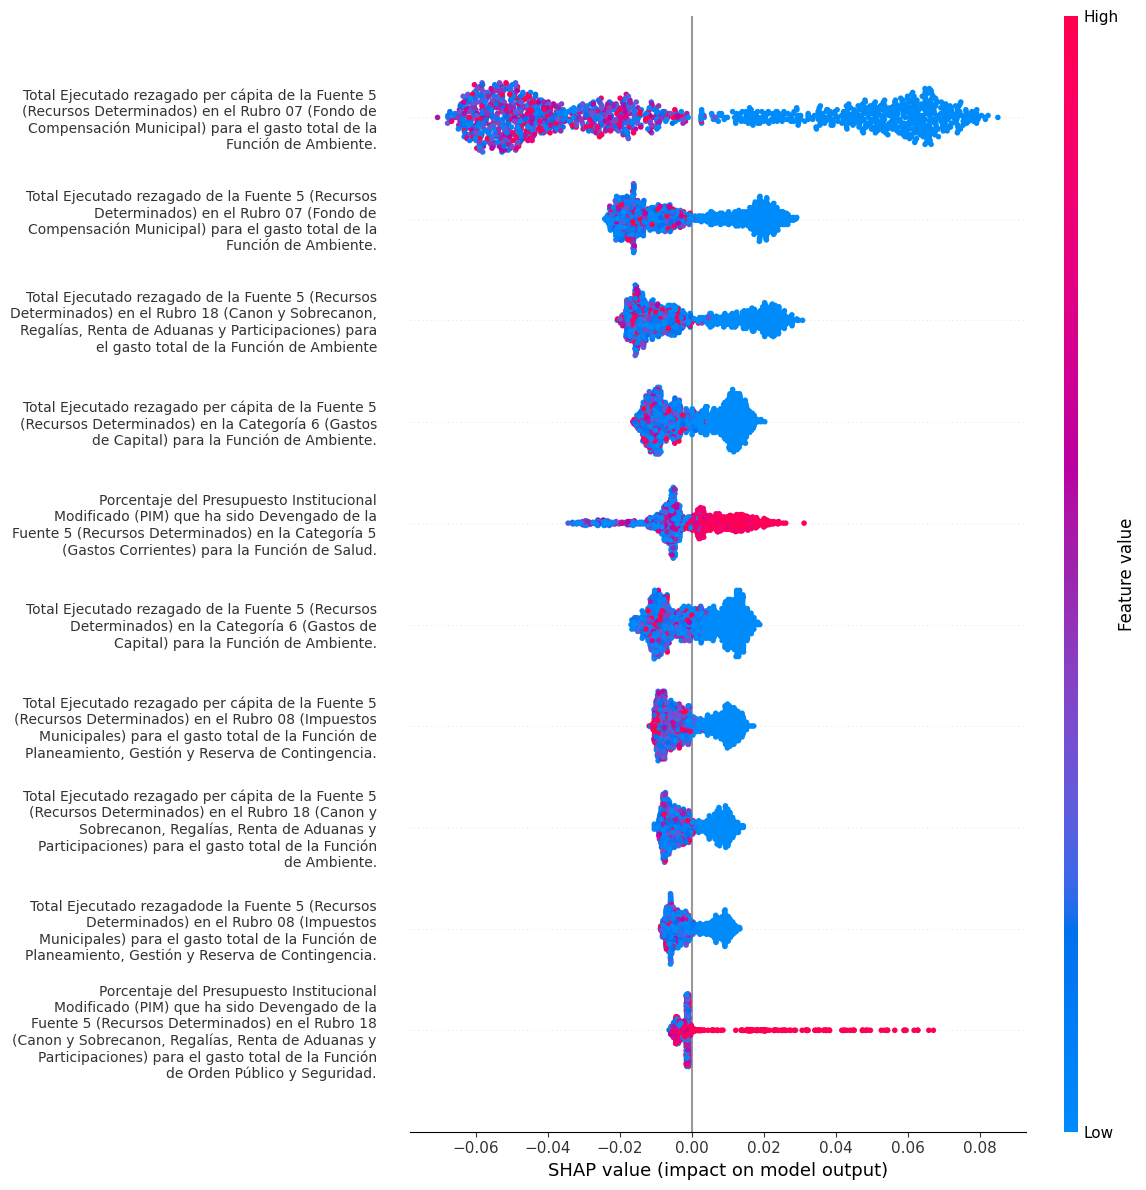

In [59]:
# Clase que se desea predecir
class_index = 1

# Variables wrapped
wrapped_feature_names = [textwrap.fill(name_mapping[name], width=50) if name in name_mapping else name for name in x_train_st.columns]
# wrapped_feature_names = [textwrap.fill(name, width=40) for name in x_train_st.columns]

# Asumiendo que shap_values ya ha sido calculado y que class_index está definido
shap_sum = np.abs(shap_values[class_index]).mean(axis=0)

# Obtener los índices de las 10 características más importantes
top_indices = np.argsort(shap_sum)[-10:]

# Si x_train es un DataFrame, usa .iloc para indexar por posición
x_train_top = x_train_st.iloc[:, top_indices]

# Filtrar feature_names para quedarnos solo con las 10 características más importantes
feature_names_top = [wrapped_feature_names[i] for i in top_indices]

# Graficar los valores SHAP para las 10 características más importantes
shap.summary_plot(shap_values[class_index][:, top_indices], x_train_top, 
                  feature_names=feature_names_top, 
                  show=False,
                  plot_size=(12, 12))

plt.yticks(fontsize=10)
plt.tight_layout()  # Ajusta la disposición de la trama
# plt.title('Top 10 SHAP Value Features for Positive Corruption Cases',
        #   fontsize = 18, fontweight = 'bold' )
plt.savefig('../../../output/ejecucion_8/plots/ci_shap_features.jpg', bbox_inches='tight')  # Guarda el gráfico
plt.show()

### 3.2. Broad Corruption

In [110]:
path = r'..\..\..\input\preprocessed_data\base0_siaf_canon_1620.csv'
data = pd.read_csv( path )

In [112]:
dep_var    = [ 'corrup_amplia' ]
other_vars = [ 'monto_examinado', 'monto_auditado', 'monto_objeto_servicio',
               'monto_corrup1', 'monto_corrup2', 'tipo_control', 'corrup_intensa',
               'per_corrup1', 'per_corrup2', '_monto', 'monto_', 'year', 'ubigeo' ]

pred_vars  = [ col for col in data.columns if col not in dep_var and col not in other_vars ]

x_train, x_test, y_train, y_test = train_test_split( data[ pred_vars ],
                                                     data[ 'corrup_amplia' ],
                                                     test_size    = 0.3,
                                                     random_state = 2023,
                                                     stratify = data[ 'corrup_amplia' ] )

In [113]:
x_train_s, x_train_st, x_train_nro, y_train_s, y_train_st, y_train_nro = fun.resampling( x_train, y_train )

In [74]:
# path         = r'..\..\..\output\ejecucion_8\models\model_ca_Regression Forest_s.joblib'
# loaded_model = joblib.load( path )
reg_forest_nro_model = RegressionForest( random_state = 2023, n_jobs = -1, n_estimators = 500, max_depth = 30 )
reg_forest_nro_model.fit(x_train_nro, y_train_nro)

RegressionForest(max_depth=30, n_estimators=500, random_state=2023)

In [75]:
explainer = shap.TreeExplainer(reg_forest_nro_model)
shap_values = explainer.shap_values(x_train_nro, approximate=False, check_additivity=False)

In [76]:
shap_sum = np.abs(shap_values).mean(axis=0)
feature_importance_df = pd.DataFrame({
    'Feature': x_train_nro.columns,
    'SHAP Value': shap_sum
})
feature_importance_df = feature_importance_df.sort_values(by='SHAP Value', ascending=False)
feature_importance_df.to_excel(r'..\..\..\output\ejecucion_8\vars\shap_varlist_ca_Regression Forest_nro.xlsx')
feature_importance_df

Feature  SHAP Value
13852  _devppimtotfun_f2cydeppc    0.055274
1443        tejgfun_f5ct05pgrco    0.016393
3429           tejgtotfun_f5viv    0.015813
1499          tejgfun_f5ct05viv    0.011230
1996     tejgfun_f5r08ct05prots    0.010458
...                         ...         ...
6921      _tejgtotfun_f5r18trab    0.000000
6920      _pimgtotfun_f5r18trab    0.000000
6919      _piagtotfun_f5r18trab    0.000000
775         tejgfun_f1ct06salud    0.000000
7802    pimgfun_f5r18ct06turipc    0.000000

[14317 rows x 2 columns]

In [114]:
name_mapping = {
    "_devppimtotfun_f2cydeppc": "Porcentaje Devengado rezagado per cápita del PIM de la Fuente 2 (Recursos Directamente Recaudados) para el gasto total de la Función 21 (Cultura y Deporte)",
    "tejgfun_f5ct05pgrco": "Total Ejecutado de la Fuente 5 (Recursos Determinados) en la Categoría 5 (Gastos Corrientes) para la Función 03 (Planeamiento, Gestión y Reserva de Contingencia)",
    "tejgtotfun_f5viv": "Total Ejecutado de la Fuente 5 (Recursos Determinados) para el gasto total de la Función 19 (Vivienda y Desarrollo Urbano)",
    "tejgfun_f5ct05viv": "Total Ejecutado de la Fuente 5 (Recursos Determinados) en la Categoría 5 (Gastos Corrientes) para la Función 19 (Vivienda y Desarrollo Urbano)",
    "tejgfun_f5r08ct05prots": "Total Ejecutado de la Fuente 5 (Recursos Determinados) en el Rubro 08 (Impuestos Municipales), Categoría 5 (Gastos Corrientes) para la Función 23 (Protección Social)",
    "_piagfun_f2ct05opsegpc": "Presupuesto Institucional de Apertura rezagado per cápita de la Fuente 2 (Recursos Directamente Recaudados) en la Categoría 5 (Gastos Corrientes) para la Función 05 (Orden Público y Seguridad)",
    "tejgfun_f5r18ct05vivpc": "Total Ejecutado per cápita de la Fuente 5 (Recursos Determinados) en el Rubro 18 (Canon y Sobrecanon, Regalías, Renta de Aduanas y Participaciones), Categoría 5 (Gastos Corrientes) para la Función 19 (Vivienda y Desarrollo Urbano)",
    "_tejgtotfun_f5viv": "Total Ejecutado rezagado de la Fuente 5 (Recursos Determinados) para el gasto total de la Función 19 (Vivienda y Desarrollo Urbano)",
    "tejgge_r09ct05otgst": "Total Ejecutado en el Rubro 09 (Recursos Directamente Recaudados), Categoría 5 (Gastos Corrientes), para la genérica de Otros Gastos.",
    "dfgpimpiatotfun_f5r08pgrco": "Diferencia entre el Presupuesto Institucional Modificado (PIM) y el Presupuesto Institucional de Apertura (PIA) de la Fuente 5 (Recursos Determinados) en el Rubro 08 (Impuestos Municipales) para la Función 03 (Planeamiento, Gestión y Reserva de Contingencia)",
    "_tejgfun_f2ct05opsegpc": "Total Ejecutado rezagado per cápita de la Fuente 2 (Recursos Directamente Recaudados) en la Categoría 5 (Gastos Corrientes) para la Función 05 (Orden Público y Seguridad)",
    "_devppimtotfun_f5trans": "Porcentaje Devengado del PIM rezagado de la Fuente 5 (Recursos Determinados) para el gasto total de la Función 15 (Transporte)",
    "_piagtotfun_f2opsegpc": "Presupuesto Institucional de Apertura (PIA) rezagado per cápita de la Fuente 2 (Recursos Directamente Recaudados) para el gasto total de la Función 05, que corresponde a Orden Público y Seguridad",
    "tejgtotfun_f5r08prots": "Total Ejecutado de la Fuente 5 (Recursos Determinados) en el Rubro 08 (Impuestos Municipales) para el gasto total de la Función 23 (Protección Social)",
    "tejgrb_impm": "Total Ejecutado en el Rubro de Impuestos Municipales",
    "_dfgdevpiagtotfun_f2opsegpc": "Diferencia entre el Total Devengado y el Presupuesto Institucional de Apertura (PIA) rezagado per cápita de la Fuente 2 (Recursos Directamente Recaudados) para el gasto total de la Función 05 (Orden Público y Seguridad)",
    "_piagtotfun_f5turi": "Presupuesto Institucional de Apertura (PIA) rezagado de la Fuente 5 (Recursos Determinados) para el gasto total de la Función 09 (Turismo)",
    "tejgfun_f5ct06viv": "Total Ejecutado de la Fuente 5 (Recursos Determinados) en la Categoría 6 (Gastos de Capital) para la Función 19 (Vivienda y Desarrollo Urbano)",
    "tejgrb_impmpc": "Total Ejecutado per cápita en el Rubro de Impuestos Municipales",
    "_tejgge_r09ct05biser": "Total Ejecutado rezagado en el Rubro 09 (Recursos Directamente Recaudados), Categoría 5 (Gastos Corrientes), para la Genérica de Bienes y Servicios",
}


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
The figure layout has changed to tight


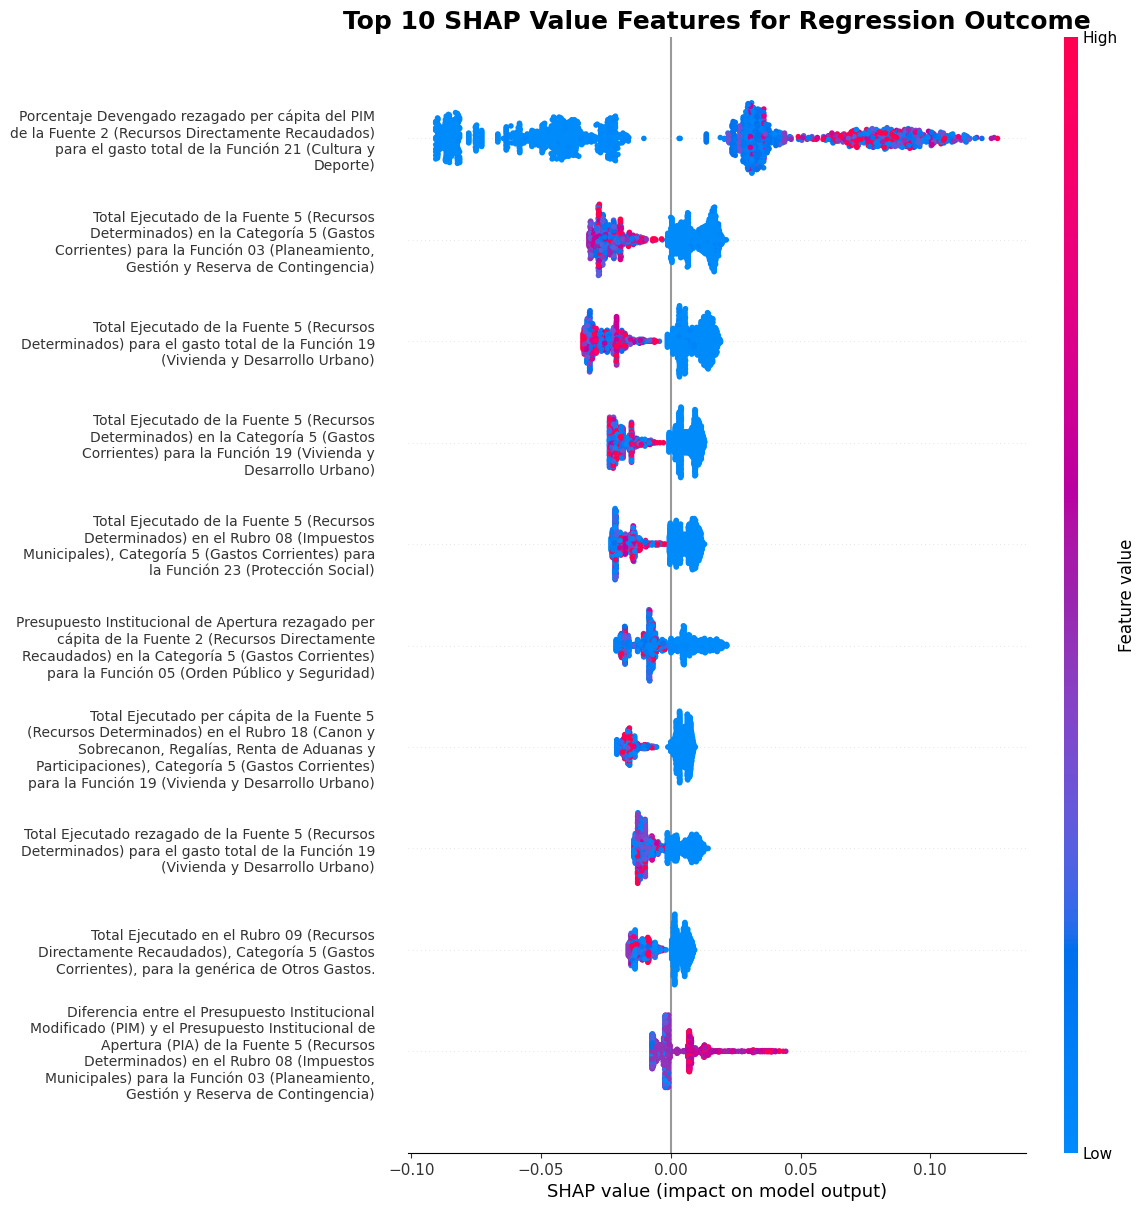

In [116]:
# Variables wrapped
wrapped_feature_names = [textwrap.fill(name_mapping[name], width=50) if name in name_mapping else name for name in x_train_nro.columns]

# Asumiendo que shap_values ya ha sido calculado para un modelo de regresión
shap_sum = np.abs(shap_values).mean(axis=0)

# Obtener los índices de las 10 características más importantes
top_indices = np.argsort(shap_sum)[-10:]

# Si x_train es un DataFrame, usa .iloc para indexar por posición
x_train_top = x_train_nro.iloc[:, top_indices]

# Filtrar feature_names para quedarnos solo con las 10 características más importantes
feature_names_top = [wrapped_feature_names[i] for i in top_indices]

# Graficar los valores SHAP para las 10 características más importantes
shap.summary_plot(shap_values[:, top_indices], x_train_top, 
                  feature_names=feature_names_top, 
                  show=False,
                  plot_size=(12, 12))

plt.yticks(fontsize=10)
plt.tight_layout()  # Ajusta la disposición de la trama
plt.title('Top 10 SHAP Value Features for Regression Outcome',
          fontsize = 18, fontweight = 'bold' )
plt.savefig('../../../output/ejecucion_8/plots/ca_shap_features.jpg', bbox_inches='tight')  # Guarda el gráfico
plt.show()